# `Практикум по программированию на языке Python`

## `Задание 05. GAN для вращения машинок`

#### Фамилия, имя: Морозов Иван

Дата выдачи: <span style="color:red">__08 мая 23:59__</span>.

Мягкий дедлайн: <span style="color:red">__22 мая 23:59__</span>.

Стоимость: __10 баллов__ (основная часть заданий) + __0 баллов__ (дополнительные задания).

<span style="color:red">__В ноутбуке все клетки должны выполняться без ошибок при последовательном их выполнении.__</span>

#### `Москва, 2024`

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import math
import copy
import random
from itertools import product
from typing import Optional, Tuple, Union, List

import glob
import regex

import scipy
import numpy as np

import PIL
import PIL.Image
!pip install sk-video
!pip install omegaconf
import skvideo.io

import matplotlib_inline
import matplotlib.pyplot as plt
from ipywidgets import Video, GridspecLayout 

import wandb
import tqdm.autonotebook as tqdm
from omegaconf import OmegaConf, DictConfig

import torch
from torch.utils.data import DataLoader, Dataset
from torch.optim.swa_utils import AveragedModel

try:
    # Необходим с torch>=2.2:
    from torch.optim.swa_utils import get_ema_multi_avg_fn
except ImportError:
    PARAM_LIST = Union[Tuple[torch.Tensor, ...], List[torch.Tensor]]

    def get_ema_multi_avg_fn(decay=0.999):
        @torch.no_grad()
        def ema_update(ema_param_list: PARAM_LIST, current_param_list: PARAM_LIST, _):
            # foreach lerp only handles float and complex
            if torch.is_floating_point(ema_param_list[0]) or torch.is_complex(
                ema_param_list[0]
            ):
                # noinspection PyProtectedMember
                torch._foreach_lerp_(ema_param_list, current_param_list, 1 - decay)
            else:
                for p_ema, p_model in zip(ema_param_list, current_param_list):
                    p_ema.copy_(p_ema * decay + p_model * (1 - decay))

        return ema_update

import torchvision.transforms.functional
import torchvision.transforms as transforms
from torchvision.utils import save_image, make_grid

#from utils_3d import fancy_integration, get_initial_rays_trig, transform_sampled_points, sample_pdf

%matplotlib inline
matplotlib_inline.backend_inline.set_matplotlib_formats('pdf', 'svg')

torch.backends.cudnn.benchmark = True
torch.use_deterministic_algorithms(False)

torch.backends.cudnn.allow_tf32 = True
torch.backends.cuda.matmul.allow_tf32 = True

torch.autograd.profiler.profile(False)
torch.autograd.profiler.emit_nvtx(False)
torch.autograd.set_detect_anomaly(False)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 9.9 MB/s eta 0:00:00:00:010:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 1.2 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 3.4 MB/s eta 0:00:00
  Created wheel for antlr4-python3-runtime: filename=antlr4_python3_runtime-4.9.3-py3-none-any.whl size=144554 sha256=f2880cc037d19e5f45a4bd7bb5c55a7c5e8959bf74e90caf37c8fbc514de2aba
  Stored in directory: /root/.cache/pip/wheels/12/93/dd/1f6a127edc45659556564c5730f6d4e300888f4bca2d4c5a88
Successfully built antlr4-python3-runtime


/tmp/ipykernel_34/3477254034.py:25: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  import tqdm.autonotebook as tqdm


In [3]:
def set_global_seed(seed: int) -> None:
    """Set global seed for reproducibility.
    :param int seed: Seed to be set
    """
    random.seed(seed)
    np.random.seed(seed)
    
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    
def check_numel(module: torch.nn.Module, params_numel: int, buffers_numel: Optional[int] = None) -> None:
    """Check whether module has correct number of parameters and buffers
    :param torch.nn.Module module: Target model
    :param int params_numel: Target number of parameters
    :param Optional[int] buffers_numel: Target number of buffers
    :rtype:
    """
    numel = sum(param.numel() for param in module.parameters())
    assert numel == params_numel, f'For params numel != correct numel: {numel} vs {params_numel}'
    
    if buffers_numel is not None:
        numel = sum(param.numel() for param in module.buffers())
        assert numel == buffers_numel, f'For buffers numel != correct numel: {numel} vs {buffers_numel}'
    
def hide_specs(module: torch.nn.Module) -> str:
    """Remove hyperparameters for model __repr__
    :param torch.nn.Module module: Target model
    :return: Cleaned up repr
    :rtype: str
    """
    module_repr = str(module)
    
    for spec in regex.findall("\(.*\): (.*)", module_repr):
        module_repr = module_repr.replace(spec, regex.sub('\(.*\)', '(...)', spec))
        
    return module_repr

# `Постановка задачи`

В этой работе вы узнаете про глубокий нейросетевой подход **Neural Radiance Fields** (NeRF) — метод для генерации новых изображений сцены с различных ракурсов. Основная задача — интерполяция новых ракурсов между исходными оригинальными изображениями для получения `непрерывной сцены` из ограниченного числа фотографий.

Neural Radiance Fields — метод глубокого обучения для генерации изображений новых любых ракурсов для конкретного фотосета. 

Как же выглядит данная нейронная сеть и как её учить? Саму нейронную сеть можно представить как сложную функцию многих переменных. На вход этой функции подаются положение точки пространства $(x, y, z)$, в которой предполагаемо находится объект, и вектор угла обзора (в случае сферических координат нам хватит углов $\phi, \theta$).

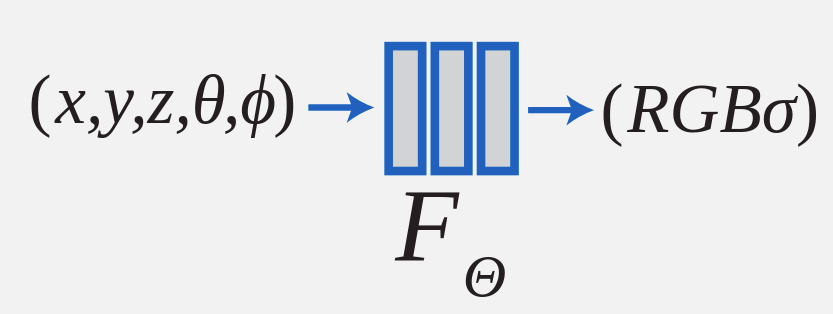

Функция $F$ возвращает $4$ числа: 
* $\sigma$ (плотность) — некоторое число, значение которого даёт нам понять, есть ли в указанной точке пространства какой-то объект или нет. Её можно считать аналогом прозрачности со значениями от $0$ до $1$
* Тройка RGB показывает значения цвета в указанной точке пространства $(x, y, z)$

$F$ параметризована полносвязной нейронной сетью. Сначала на вход подаются координаты $(x, y, z)$. Выход из этой части сети это плотность $\sigma$ и $\text{c}$ — три компоненты RGB цвета.

Направления $\theta$, $\phi$ необходимы для учета направления "взгляда", чтобы более точно моделировать эффекты отражения и освещенности и консистентно их обобщать в каждой точке пространства.

Почему модель называется Neural Radiance Fields? Дело в том, что через каждую точку пространства проходят лучи, задаваемые радиальными координатами $\theta$ и $\phi$. На каждом луче задается некоторое распределение $\sigma(x)$ для того, чтобы моделировать непрерывный объём, `volume`, внутри пространства и показывать, в какой момент возникает препятствие на пути луча. Таким образом, учится распределение внутри объёма - прямая альтернатива вокселизации.

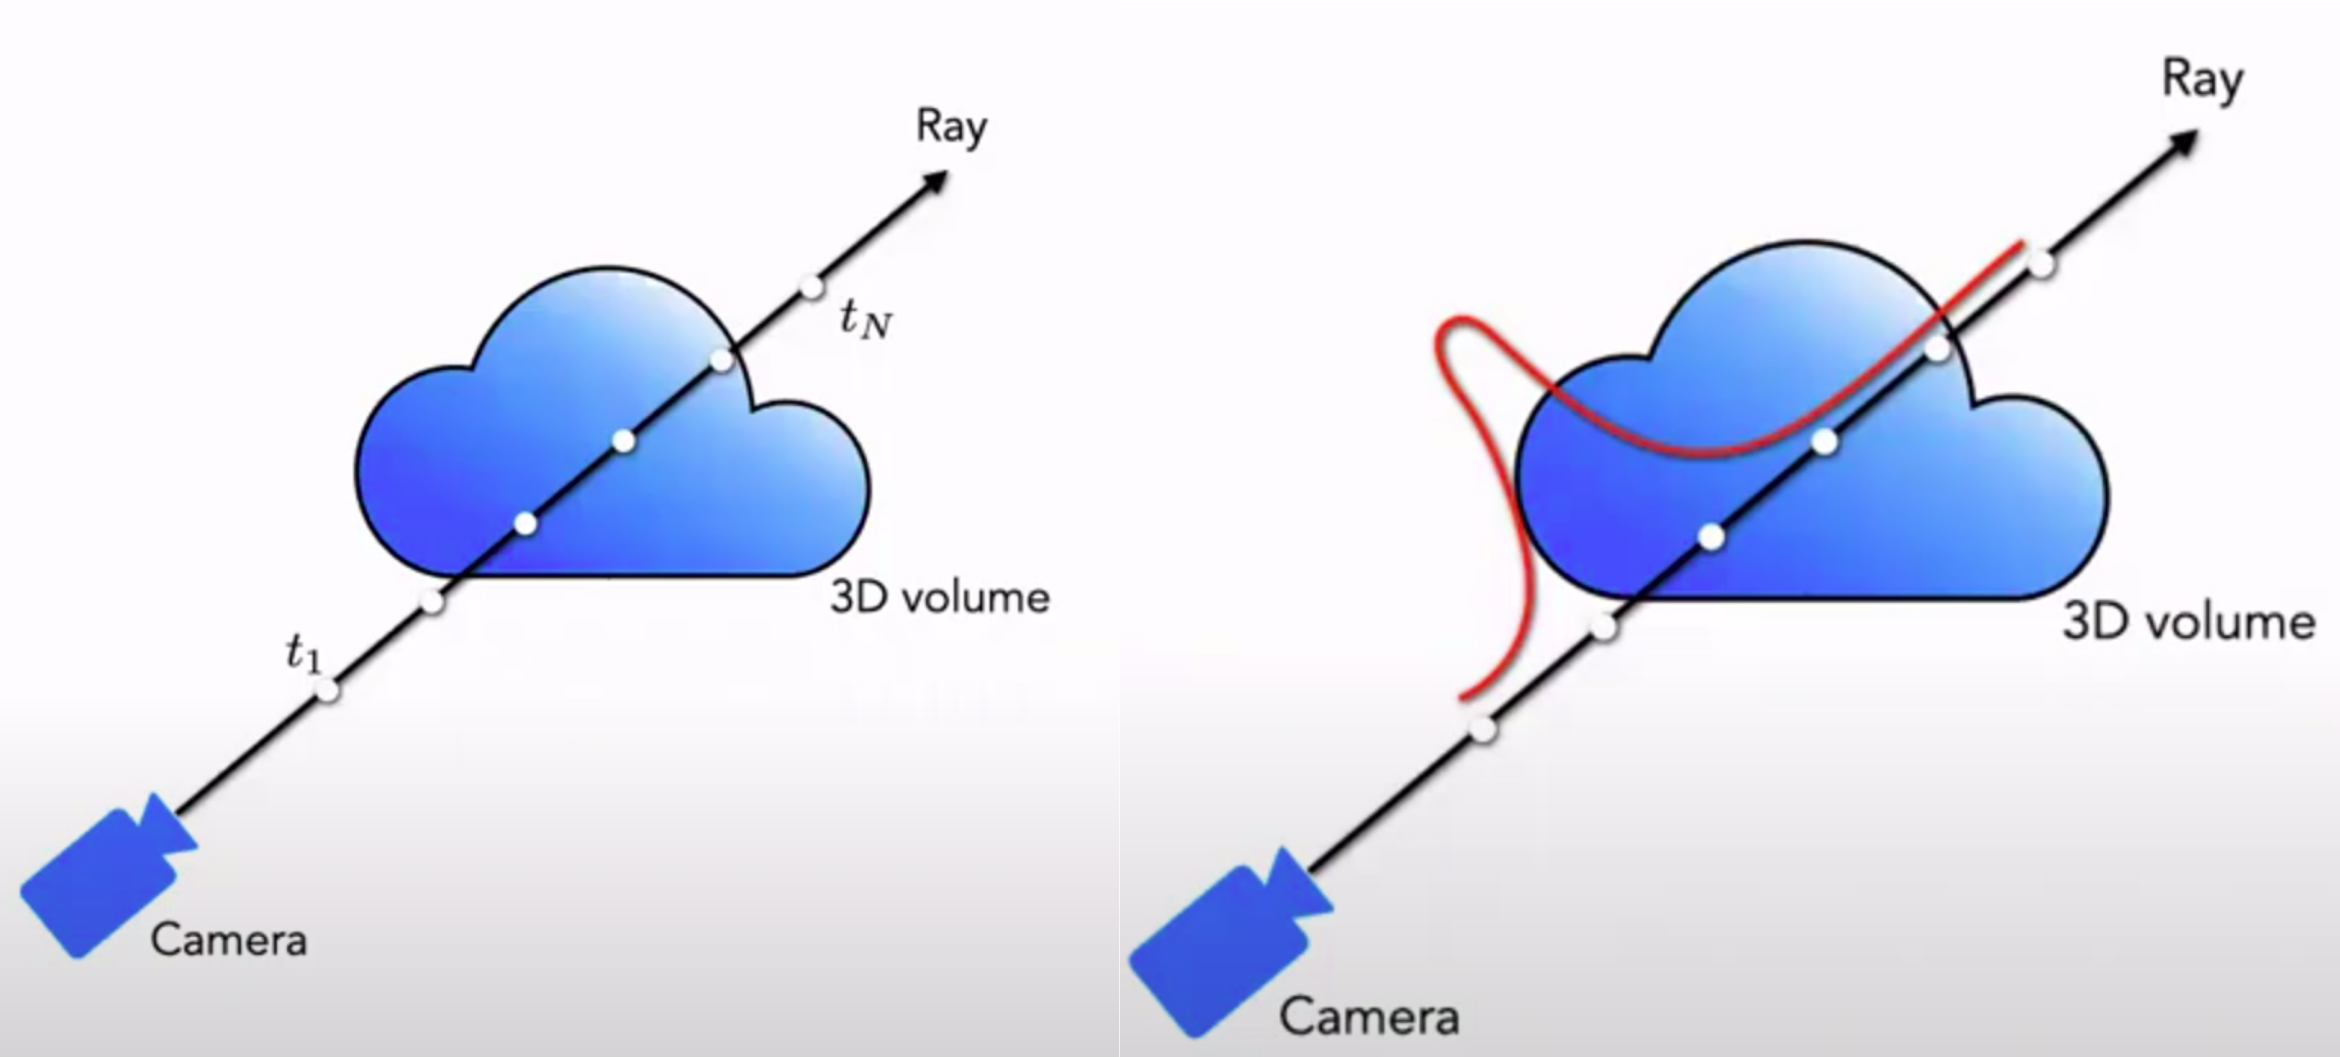

[Изображение взято с Habr](https://habr.com/ru/companies/twin3d/articles/569174/)

На практике оказывается удобнее задавать направление "взгляда" не через углы, а соответствующим единичным вектором $\textbf{d} \in \mathbb{R}^{3}, ||\textbf{d}|| = 1$.

Параметры $t_{1}$ и $t_{N}$ задают границы объекта. Данные значения могут быть получены с помощью других методов и в этой работе они вам уже заданы.

Среднее значение цвета на луче $\textbf{r}$:

$$\textbf{r}(t) = \textbf{o} + t \textbf{d} \tag{1}$$

между ближней и дальней границами $t_{1}, t_{N}$ вычисляется следующим образом:

$$\mathbf{C} (\mathbf{r}) = \int_{t_1}^{t_N} T(t) \sigma \left(\mathbf{r}(t) \right) \text{c} \left(\mathbf{r}(t),d \right)dt, \quad
T(t)  = \text{exp} \left(-\int_{t_1}^{t}\sigma(\mathbf{r}(s))ds \right). \tag{2}$$

Функция $T(t)$ обозначает накопленный коэффициент пропускания вдоль луча от $t_1$ до $t_N$, то есть вероятность того, что луч пройдет от $t_1$ до $t_N$, не задев ни одну другую частицу.

По сути, мы имеем модель для восстановления цвета и плотности распределения на луче, интегрируя которые можно получить видимый цвет вдоль каждого направления. Очевидно, что уравнение $(2)$ невозможно проинтегрировать аналитически, поэтому логичным вариантом является численная аппроксимация (например, stratified sampling, по сути, аналог Монте-Карло оценки).

Между значениями $ t_1$ и $t_ N$ сэмплируем $N$ точек $t$ (которым соответствуют шестёрки $(x, y, z, \textbf{d})$) в которых будет вычислены значения:

$$\sigma(\mathbf{r}(t)), \text{c}(\mathbf{r}(t)) = F_{\Theta}(x, y, z, \textbf{d}) \tag{3}$$

Заметим, что величина $\mathbf{C} (\mathbf{r})$ дифференцируема по параметрам $\Theta$, и мы можем использовать градиентные методы, чтобы оптимизировать NeRF.

В этом домашнем задании вам необходимо обучить генеративную состязательную сеть, генератор которой работает на основе NeRF модели. Функции отвечающие за подсчет интегралов и все математические формулы используемые в NeRF представлены в модуле `utils_3d`.

Для более стабильного обучения дискриминатора, нам необходимо, чтобы данные были в диапазоне $[-1, 1]$. Кроме того мы будем использовать архитектуру дискриминатора как в статье [Progressive Growing of GANs](https://arxiv.org/abs/1710.10196), то есть в зависимости от итерации обучения мы будем менять разрешения генерируемых изображений.

Для более полного понимания задания необходимо ознакомиться со следующими статьями:
1. Основная архитектура модели: [pi-GAN](https://arxiv.org/abs/2012.00926)
2. Описание дискриминатора: [Progressive Growing of GANs](https://arxiv.org/abs/1710.10196)
3. Описание [NeRF](https://arxiv.org/pdf/2003.08934)
4. Описание [функции потерь и базового подхода к обучению GAN](https://arxiv.org/pdf/1406.2661). Особое внимание уделите Секции $3$ и описанию Non-Saturating Loss

## `Рекомендуемые гиперпараметры`

In [4]:
config = OmegaConf.create()

# Путь к данным
config.template = './carla/*.png'

# Параметры модели
config.z_dim = 256
config.hidden_dim = 256
config.n_blocks = 8

# Параметры для обучения GAN
config.r1_lambda = 5
config.ema_rate = 0.999

# Параметры оптимизатора
config.betas = (0, 0.9)
config.weight_decay = 0
config.grad_clip = 1.0

# Расписание обучения
config.train_config = [
    (0,          {'batch_size': 32, 'img_size': 32, 'gen_lr': 6e-5, 'disc_lr': 2e-4}),
    (10_000,     {'batch_size': 10, 'img_size': 64, 'gen_lr': 3e-5, 'disc_lr': 1e-4}),
]

# Гиперпарметры для 3D рендеринга и численного интегрирования
config.fov = 30
config.ray_start = 0.7
config.ray_end = 1.3
config.fade_steps = 10_000

config.h_stddev =  math.pi
config.v_stddev = math.pi / 4 * 85 / 90

config.v_mean =  math.pi / 4 * 85 / 90
config.h_mean = math.pi / 2

config.num_steps = 12

# Визуализация
config.img_size_vis = 64

Для удобства, определим вспомогательную функцию, которая для текущего шага обучения возвращает конфиг с текущими параметрами обучения:

In [5]:
def extract_training_config(current_step: int, config: DictConfig) -> Tuple[int, DictConfig]:
    """Helper function to retrieve training params for the current step from a config
    :param int current_step:
    :param DictConfig config:
    :rtype: Tuple[int, DictConfig]
    """
    for start_step, train_config in config.train_config[::-1]:
        if start_step <= current_step:
            return start_step, train_config
            
    raise TypeError('current_step is invalid')

# `Часть 0. Загрузка и предобработка данных (1 балл)`

В этой работе мы будем использовать синтетический датасет [CARLA](https://paperswithcode.com/dataset/carla), полученный из рендера моделей (в частности рендер автомобилей). Загрузим необходимые данные:

In [6]:
if not (os.path.exists('./carla.zip') or os.path.exists('./carla')):
    ! wget https://s3.eu-central-1.amazonaws.com/avg-projects/graf/data/carla.zip
        
if not os.path.exists('./carla'):
    ! unzip carla.zip -d carla

--2024-05-22 13:17:29--  https://s3.eu-central-1.amazonaws.com/avg-projects/graf/data/carla.zip
Resolving s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)... 3.5.136.2, 52.219.75.111, 52.219.171.53, ...
Connecting to s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)|3.5.136.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 866895061 (827M) [application/zip]
Saving to: 'carla.zip'

carla.zip           100%[===================>] 826.74M  30.7MB/s    in 35s     

2024-05-22 13:18:05 (23.4 MB/s) - 'carla.zip' saved [866895061/866895061]

  inflating: carla/000555.png        
  inflating: carla/000556.png        
  inflating: carla/000557.png        
  inflating: carla/000558.png        
  inflating: carla/000559.png        
  inflating: carla/000560.png        
  inflating: carla/000561.png        
  inflating: carla/000562.png        
  inflating: carla/000563.png        
  inflating: carla/000564.png        
  inflating: carla/000565.png

In [7]:
sorted(os.listdir('./carla'))[:5] + sorted(os.listdir('./carla'))[-5:], len(os.listdir('./carla'))

(['000000.png',
  '000001.png',
  '000002.png',
  '000003.png',
  '000004.png',
  '009996.png',
  '009997.png',
  '009998.png',
  '009999.png',
  'LICENSE.txt'],
 10001)

Для работы с изображениями реализуем простейший датасет. Параметр `img_size`будет отвечать за разрешение изображения, которое будет меняться во время обучения, так как мы используем Progressive Growing GAN.

**Tips:**
1. Сортируйте изображения, для большей детерминированности
2. Нормализуйте изображения со средним $0.5$ и такой же дисперсией
3. Используйте `transforms.functional.InterpolationMode.NEAREST` интерполяцию при масштабировании изображений

In [8]:
from PIL import Image
class Carla(Dataset):
    """Carla Dataset"""

    def __init__(self, template: str, img_size: int):
        """
        :param str template: path to the images
        :param int img_size: target image size
        """
        super().__init__()
        
        files = sorted(glob.glob(template))
        self.images_paths = np.array(files)
        
        self.transform = transforms.Compose([
            transforms.Resize(img_size, transforms.InterpolationMode.NEAREST),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5], std=[0.5])
        ])
        
    def __len__(self) -> int:
        """
        Number of images
        :rtype: int
        """
        
        return len(self.images_paths)
    
    def __getitem__(self, idx: int) -> torch.Tensor:
        """
        :param int idx: Image Id
        :return: Image of desired image size
        :rtype: torch.Tensor
        """
        
        img_path = self.images_paths[idx]
        image = Image.open(img_path).convert('RGB')
        image = self.transform(image)
        return image

Сразу же определим трансформацию, переводящие тензоры обратно в изображения:

In [9]:
inverse_transform = transforms.Compose([
    transforms.Normalize(mean=[-1], std=[2.0]),
    transforms.ToPILImage()
])

Проверим датасет и обратное преобразование:

In [10]:
dataset = Carla(config.template, img_size=64)

assert len(dataset) == 10000
assert dataset[0].shape == (3, 64, 64)
assert -1.0 <= dataset[1].min() and dataset[2].max() <= 1.0
assert isinstance(inverse_transform(dataset[3]), PIL.Image.Image)

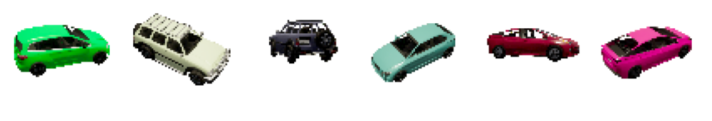

In [11]:
fig, axes = plt.subplots(1, 6, figsize=(10, 3))

for idx, ax in enumerate(axes):
    ax.imshow(inverse_transform(dataset[idx]))
    ax.axis('off')
    
fig.tight_layout()
plt.show()

Также реализуем вспомогательную функцию, чтобы получать датасет и даталоадер для изображений разного разрешения:

In [12]:
def get_dataloader(template, img_size: int, batch_size: int, shuffle: bool = True) -> DataLoader:
    """
    :param str template: path to the images
    :param int img_size: target image size
    :param int batch_size: target batch size
    :param bool shuffle: whether to shuffle data in the Dataloader
    :return: Dataloader that encapsulate Dataset with the specified image resolution
    :rtype: DataLoader
    """
    
    dataset = Carla(template=template, img_size=img_size)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)
    
    return dataloader

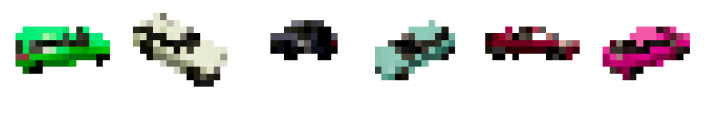

In [13]:
dataloader = get_dataloader(config.template, img_size=16, batch_size=6, shuffle=False)

images = next(iter(dataloader))

assert images.shape == (6, 3, 16, 16)
assert len(dataloader.dataset) == 10000

fig, axes = plt.subplots(1, 6, figsize=(10, 3))

for idx, ax in enumerate(axes):
    ax.imshow(inverse_transform(images[idx]))
    ax.axis('off')
    
fig.tight_layout()
plt.show()

Визуализируем датасет, чтобы понять, как влияет параметр `img_size` на изображения:

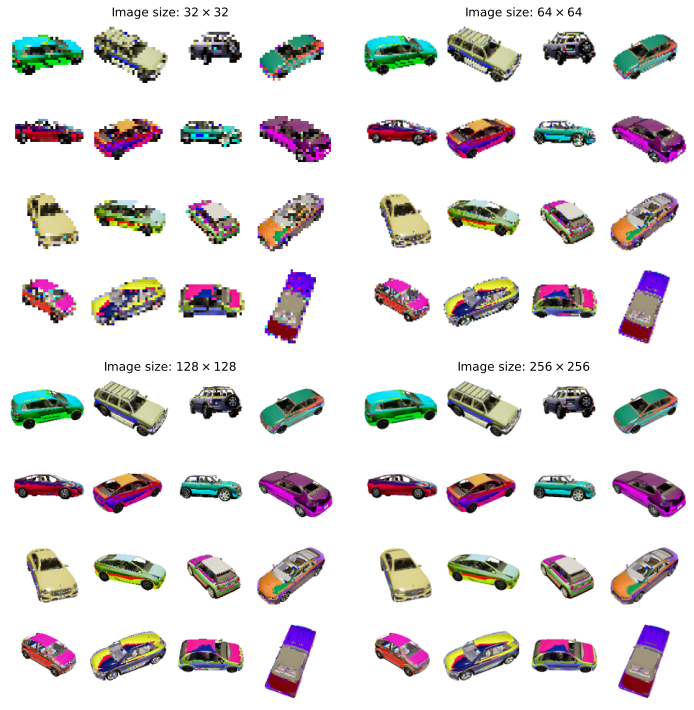

In [14]:
batch_size = 16
nrow = int(math.sqrt(batch_size))

img_sizes = [32, 64, 128, 256]

fig, axes = plt.subplots(2, 2, figsize=(10, 10))

for img_size, ax in zip(img_sizes, axes.reshape(-1)):
    dataloader = get_dataloader(config.template, img_size=img_size, batch_size=batch_size, shuffle=False)

    images = next(iter(dataloader))
    images_grid = make_grid(images, nrow, padding=0)
    images_grid = transforms.ToPILImage()(images_grid)
    
    ax.imshow(images_grid)
    
    ax.axis('off')
    ax.set_title(fr'Image size: ${img_size} \times {img_size}$')

fig.tight_layout()
plt.show()

В низком разрешение сохраняются лишь общие формы и цвет автомобиля, при увеличении разрешения можно заметить все больше деталей, например, прозрачные окна.

# `Часть 1. NeRF (3 балла)`

## `Иницилизация весов`

Для более стабильного обучения, мы будем использовать следующие инициализации весов:

Инициализация слоёв перед активацией `LeakyReLU`:

In [15]:
@torch.no_grad()
def kaiming_leaky_init(module: torch.nn.Module) -> None:
    """
    :param torch.nn.Module module: Module to initialize weights
    """
    if isinstance(module, torch.nn.Linear):
        torch.nn.init.kaiming_normal_(module.weight, a=0.2, mode='fan_in', nonlinearity='leaky_relu')

Инициализация первого блока SIREN ($\phi_{0}$):

In [16]:
@torch.no_grad()
def first_layer_film_sine_init(module: torch.nn.Module) -> None:
    """
    :param torch.nn.Module module: Module to initialize weights
    """
    if isinstance(module, torch.nn.Linear):
        num_input = module.weight.size(-1)
        h = 1 / num_input
        torch.nn.init.uniform_(module.weight, -h, h)

Инициализация для остальных блоков SIREN ($\phi_{1}, \dots, \phi_{n-1}, \phi_{c}$):

In [17]:
INIT_FREQ = 25.0

@torch.no_grad()       
def frequency_init(module: torch.nn.Module) -> None:
    """
    :param torch.nn.Module module: Module to initialize weights
    """
    if isinstance(module, torch.nn.Linear):
        num_input = module.weight.size(-1)
        h = np.sqrt(6 / num_input) / INIT_FREQ
        torch.nn.init.uniform_(module.weight, -h, h)

## `Siren`

Для представления 3D объектов мы будем использовать NeRF модель, то есть нам необходимо определить $\sigma(\textbf{x})$, $\text{c}(\textbf{x}, \textbf{d})$, где $\textbf{x} = (x, y, z)$ — координата точки и $\textbf{d}$ — направление взгляда:

$$\sigma(\textbf{x}) :  \mathbb{R}^3 \to \mathbb{R}$$
$$\text{c}(\textbf{x}, \textbf{d}) :  \mathbb{R}^6 \to \mathbb{R}^3$$

Мы будем использовать архитектуру SIREN, предложенную в работе [Implicit Neural Representations with Periodic Activation Functions](https://arxiv.org/abs/2006.09661). 

Ниже представлена архитектура подходящая нам:

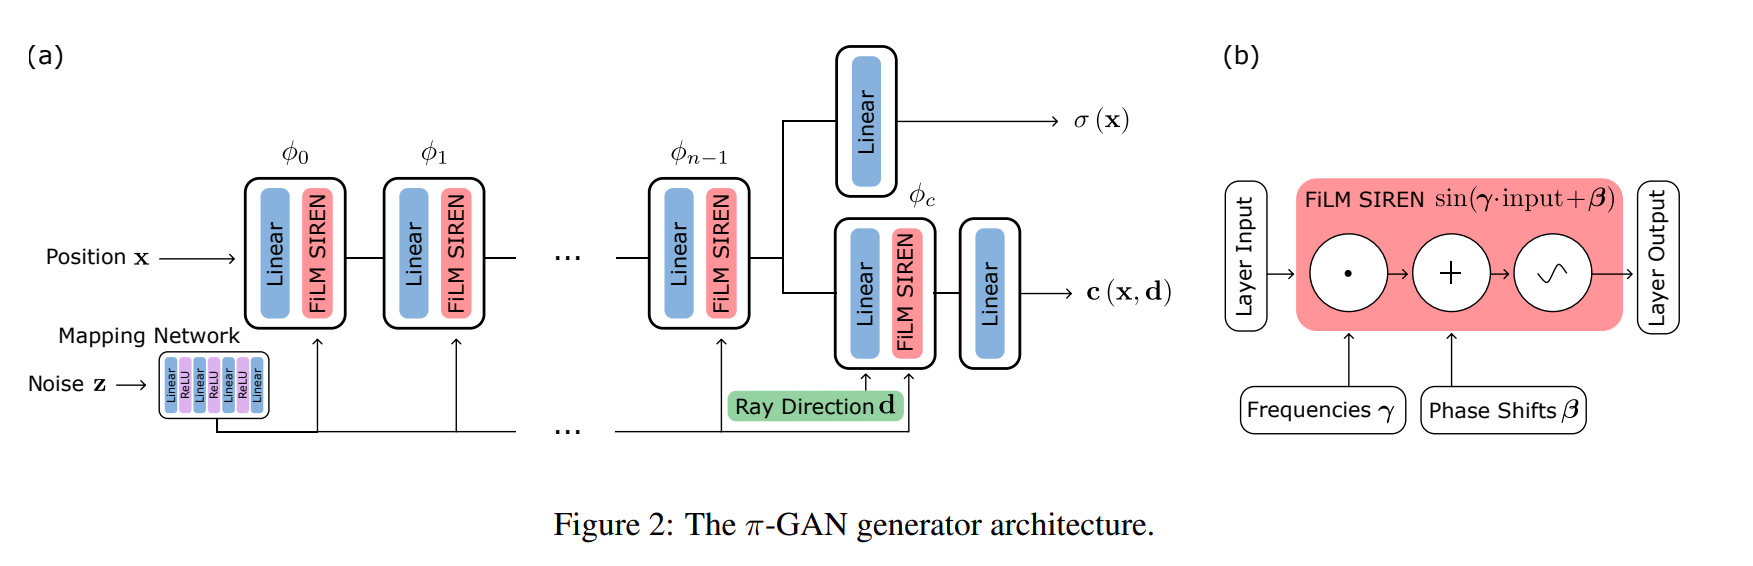

### `Mapping Network (0.5 балла)`

Mapping Network — полносвязнная нейронная сеть, которая преобразует шум в параметры периодических активаций FiLM SIREN блока: частоты $\gamma$ и фазовые сдвиги $\beta$ (разные для каждого блока $\phi_i$).

Архитектура описана на изображении: $4$ линейных слоя, разделённых функцией активации `LeakyReLU` с `negative_slope=0.2`.

В данном слое помимо инициализации Кайминга для LeakyReLU используется дополнительный трюк: веса последнего слоя предлагается уменьшить в $4$ раза (не забудьте сделать это без учета градиента).

In [18]:
class MappingNetwork(torch.nn.Module):
    def __init__(self, z_dim: int, hidden_dim: int, output_dim: int):
        """
        :param int z_dim: Noise size
        :param int hidden_dim: Hidden dimension for Feed Forward Layers
        :param int output_dim: Output dimension for the module
        """
        super().__init__()

        self.network = torch.nn.Sequential(
            torch.nn.Linear(z_dim, hidden_dim),
            torch.nn.LeakyReLU(0.2),
            torch.nn.Linear(hidden_dim, hidden_dim),
            torch.nn.LeakyReLU(0.2),
            torch.nn.Linear(hidden_dim, hidden_dim),
            torch.nn.LeakyReLU(0.2),
            torch.nn.Linear(hidden_dim, output_dim)
        )
        
        # Apply weights initialization
        self.network.apply(kaiming_leaky_init)
        with torch.no_grad():
            self.network[-1].weight.data *= 0.25
            self.network[-1].bias.data *= 0.25

    def forward(self, z: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        :param torch.Tensor z: Batch of noise of shape (B, z_dim)
        :return: Tensors with frequencies and phase shifts of shape (B, output_dim // 2)
        """
        
        x = self.network(z)
        frequencies, phase_shifts = x.chunk(2, dim=-1)
        
        return frequencies, phase_shifts

In [19]:
mapping_network = MappingNetwork(
    z_dim=13, hidden_dim=17, output_dim=13 * 41 * 2
)
print(hide_specs(mapping_network))
check_numel(mapping_network, 20038, 0)

z = torch.tensor(np.random.default_rng(1).normal(size=(7, 13)), dtype=torch.float32)
frequencies, phase_shifts = mapping_network(z)

assert frequencies.shape == (7, 13 * 41)
assert phase_shifts.shape == (7, 13 * 41)
assert np.isclose(
    torch.var(mapping_network.network[-3].weight).item(),
    2 / (1 + 0.2 ** 2) / 17, atol=1e-1
)
assert np.isclose(
    torch.var(mapping_network.network[-1].weight).item() * 16,
    2 / (1 + 0.2 ** 2) / 17, atol=1e-2
)

MappingNetwork(
  (network): Sequential(
    (0): Linear(...)
    (1): LeakyReLU(...)
    (2): Linear(...)
    (3): LeakyReLU(...)
    (4): Linear(...)
    (5): LeakyReLU(...)
    (6): Linear(...)
  )
)


### `FiLM (Feature-wise Linear Modulation) (0.5 балла)`

В качестве FiLM блока предлагается использовать следующую архитектуру, что соответствует объединению в один блок линейного слоя и слоя FiLM SIREN:

```python
    x = Linear(x)
    out = sin(freq * x + phase_shift)
```

Для генерации изображения из шума нам необходимо определять цвет для каждого пикселя в изображении. Так как используется Монте-Карло оценка выражения $(2)$, для каждого пикселя необходимо вычислить некоторое количество точек вдоль луча, который задаёт положение пикселя. Количество сэмплируемых точек на луче определяется параметром `config.num_steps`. Как следствие, для одного изображения нем необходимо сделать прямой проход для $H \times W \times \text{num_steps}$ точек через модель. Здесь и далее мы будем работать с батчами точек размера `(B, H * W * num_steps, 3) = (B, N, 3)`.

In [20]:
class FiLMLayer(torch.nn.Module):
    def __init__(self, in_features: int, out_features: int):
        """
        :param int in_features: Input dimension
        :param int out_features: Output dimension
        """
        super().__init__()
        
        self.layer = torch.nn.Linear(in_features, out_features)
        
    def forward(self, x: torch.Tensor, frequency: torch.Tensor, phase_shift: torch.Tensor) -> torch.Tensor:
        """
        :param torch.Tensor x: (B, N, in_features)
        :param torch.Tensor frequency: (B, out_features)
        :param torch.Tensor phase_shift: (B, out_features)
        :return: (B, N, out_features)
        :rtype: torch.Tensor
        """
        
        # Apply linear layer
        x = self.layer(x)
        
        # Apply FiLM
        frequency = frequency.unsqueeze(1)
        phase_shift = phase_shift.unsqueeze(1)
        x = torch.sin(frequency * x + phase_shift)
        
        return x

In [21]:
film = FiLMLayer(in_features=13, out_features=19)
print(hide_specs(film))
check_numel(film, 266, 0)

FiLMLayer(
  (layer): Linear(...)
)


In [22]:
x = torch.tensor(np.random.default_rng(2).normal(size=(7, 32 * 32 * 12, 13)), dtype=torch.float32)
frequencies = torch.tensor(np.random.default_rng(3).normal(size=(7, 19)), dtype=torch.float32)
phase_shifts = torch.tensor(np.random.default_rng(4).normal(size=(7, 19)), dtype=torch.float32)

out = film(x, frequencies, phase_shifts)
assert out.shape == (7, 32 * 32 * 12, 19)

In [23]:
x = torch.ones((7, 32 * 32 * 12, 13))

out = film(x, torch.zeros(7, 19), torch.full((7, 19), torch.pi / 2))
assert torch.sum(out).item() == 7 * 32 * 32 * 12 * 19

In [24]:
x = torch.zeros((7, 32 * 32 * 12, 13))

film.layer.bias.data.fill_(1.0)
out = film(x, torch.full((7, 19), torch.pi), torch.full((7, 19), -torch.pi / 2))
assert torch.sum(out).item() == 7 * 32 * 32 * 12 * 19

### `SIREN (0.5 балла)`

Перейдем к написанию модели SIREN. Будем использовать архитектуру, представленную на изображении выше с $8$ блоками ($\phi_0, \ldots, \phi_7$).

Также, учтём в архитектуре, что $\text{c}(\textbf{x}, \textbf{d}) \in [0, 1]^{3}$ и поверх головы, возвращающей цвет точки, добавим сигмоиду.

Заметим, направление взгляда на объект $\textbf{d}$ определяет то, как будет происходить прямой проход через нейронную сеть. После того как для облака точек были вычислены значения плотности и цвета, можно поменять направление взгляда в процессе интегрирования. Мы будем использовать следующий подход: на этапе инференса $\textbf{d} = (0, 0, -1)$ — фиксированно, а направление взгляда будет определяться параметрами внутри функций для работы с 3D: `fov`, `h_mean`, `v_mean`.

In [25]:
class SIREN(torch.nn.Module):
    """Primary SIREN architecture used in pi-GAN generators."""

    def __init__(self, hidden_dim: int, n_blocks: int):
        """
        :param int hidden_dim: Hidden dimension of FiLM blocks
        :param int n_blocks: Number of FiLM blocks
        """
        
        super().__init__()
        
        self.hidden_dim = hidden_dim
                
        # Create main backbone
        self.network = torch.nn.ModuleList()
        self.network.append(FiLMLayer(3, hidden_dim))
        for _ in range(n_blocks - 1):
            self.network.append(FiLMLayer(hidden_dim, hidden_dim))
        
        # Create sigma head
        self.sigma_head = torch.nn.Linear(hidden_dim, 1)
        
        # Create FiLM layer for RGB head
        self.rgb_head_film = FiLMLayer(hidden_dim + 3, hidden_dim)
        
        # Create linear layer for RGB head
        self.rgb_head_linear = torch.nn.Sequential(
            torch.nn.Linear(hidden_dim, 3),
            torch.nn.Sigmoid()
        )
        
        # Apply weights initialization
        self._initialize_weights()
        
        self.n_blocks = n_blocks
    
    def _initialize_weights(self):
        for i, module in enumerate(self.network):
            if i == 0:
                first_layer_film_sine_init(module.layer)
            else:
                frequency_init(module.layer)
                
        frequency_init(self.rgb_head_film.layer)


    def forward(
        self, x: torch.Tensor, ray_directions: torch.Tensor,
        frequencies: torch.Tensor, phase_shifts: torch.Tensor
    ) -> torch.Tensor:
        """
        :param torch.Tensor x: 3D points (B, N, 3)
        :param torch.Tensor ray_directions: Ray directions (B, N, 3)
        :param torch.Tensor frequencies: Frequencies to modulate FiLM layers (B, (n_blocks + 1) * hidden_dim)
        :param torch.Tensor phase_shifts: Phase shifts to modulate FiLM layers (B, (n_blocks + 1) * hidden_dim)
        :return: RGB, sigma for each point (B, N, 4)
        :rtype: torch.Tensor
        """
        # Fix view direction on the inference
        if not self.training:
            ray_directions = torch.zeros_like(ray_directions)
            ray_directions[..., -1] = -1
        
        # Some magic rescaling
        frequencies = frequencies * 15 + 30
        
        # Apply FiLM layers
        for i, layer in enumerate(self.network):
            x = layer(x, frequencies[:, i * self.hidden_dim:(i + 1) * self.hidden_dim],
                         phase_shifts[:, i * self.hidden_dim:(i + 1) * self.hidden_dim])
        
        # Apply sigma head
        sigma = self.sigma_head(x)
        
        
        # Apply RGB head
        x = torch.cat([x, ray_directions], dim=-1)
        rgb_film = self.rgb_head_film(x, frequencies[:, self.n_blocks * self.hidden_dim:],
                                      phase_shifts[:, self.n_blocks * self.hidden_dim:])
        
        rgb = self.rgb_head_linear(rgb_film)
        
        x = torch.cat([rgb, sigma], dim=-1)
        return x

In [26]:
mapping_network = MappingNetwork(z_dim=13, hidden_dim=19, output_dim=2 * (7 + 1) * 31)   
siren = SIREN(31, 7)

print(hide_specs(siren))
check_numel(siren, 7289, 0)

z = torch.tensor(np.random.default_rng(5).normal(size=(7, 13)), dtype=torch.float32)
x = torch.tensor(np.random.default_rng(6).normal(size=(7, 32 * 32 * 12, 3)), dtype=torch.float32)
ray_directions = torch.tensor(np.random.default_rng(7).normal(size=(7, 32 * 32 * 12, 3)), dtype=torch.float32)

frequencies, phase_shifts = mapping_network(z)
rgb_sigma = siren(x, ray_directions, frequencies, phase_shifts)
rgb, sigma = torch.split(rgb_sigma, [3, 1], dim=-1)

assert rgb_sigma.shape == (7, 32 * 32 * 12, 4)
assert torch.all(0.0 < rgb) and torch.all(rgb <= 1.0)

SIREN(
  (network): ModuleList(
    (0): FiLMLayer(
      (layer): Linear(...)
    )
    (1-6): 6 x FiLMLayer(
      (layer): Linear(...)
    )
  )
  (sigma_head): Linear(...)
  (rgb_head_film): FiLMLayer(
    (layer): Linear(...)
  )
  (rgb_head_linear): Sequential(
    (0): Linear(...)
    (1): Sigmoid(...)
  )
)


## `Генератор (1.5 балла)`

Генератор является оберткой над моделью SIREN, а именно содержит все необходимые функции для рендеринга, сэмплирования точек и генерации лучей. Можно сказать, что вся работа с 3D реализована именно в классе генератора.

Опишем процедуру генерации изображения из шума:
1. Прямой проход через mapping network для генерации параметров, модулирующих FiLM слои
2. Генерация начальных точек: детерминировано, для каждого пикселя равномерно выбираются точки вдоль луча, определяемого пикселем. Логика работы сокрыта внутри функции `gen_camera_rays_points`
3. Предсказание $\text{RGB}, \sigma$ для начальных точек

На практике, использование только значений в равномерно распределённых вдоль луча точках даёт результаты недостаточно высокого качества. Для улучшения качества генерации используется следующий трюк: с помощью importance sampling определяются области, в которых желательно вычислить значение цвета для улучшения качества рендеринга

4. Вычисление "fine" точек. Логика работы сокрыта внутри функции `gen_fine_points`
5. Предсказание $\text{RGB}, \sigma$ для "fine" точек
6. Рендеринг итогового изображения из облака начальных и "fine" точек. Логика работы сокрыта внутри функции `get_pixels`

**Tips:**

* Функция `gen_camera_rays_points` возвращает пятёрку: начальные точки $\textbf{x}$, начальные направления $\textbf{d}$, положения точек на луче $t$, направления для каждого пикселя и точку обзора для каждого пикселя $\textbf{o}$. При этом для получения "fine" точек недостаточно вызвать `gen_fine_points` — она вычисляет только положение "fine" точек на луче. Сами точки необходимо вычислить используя выражение $(1)$. Для вашего удобства `gen_camera_rays_points` возвращает $4$ аргументом направления, в более удобном представлении для вычисления по формуле $(1)$.

Для улучшения качества генерации на инференсе используется стандартный приём — **truncation trick**.

Первые реализации этого трюка изменяли распределение, из которого сэмплировался случайный шум, что улучшало качество генерации: [Megapixel Size Image Creation using GANs, Figure 4](https://arxiv.org/pdf/1706.00082v1), [LARGE SCALE GAN TRAINING FOR HIGH FIDELITY NATURAL IMAGE SYNTHESIS, Section 3.1](https://arxiv.org/pdf/1809.11096). Однако с появлением StyleGAN подобных моделей (pi-GAN в частности является такой моделью, ключевым признаком является наличие mapping network, в которой заложена работа с недетерминированным шумом) была придумана модификация данного метода.

Обозначим за $\mathcal{M}$ — mapping network, $\mathcal{G}$ — оставшаяся часть генератора.

Обозначим за $\mathcal{Z}$ — пространство шума, $\mathcal{W} = \mathcal{M}(\mathcal{Z})$ пространство задаваемое mapping network.

Тогда **truncation trick** в пространстве $\mathcal{W}$ определяется следующим образом:

$$
I(z) = \mathcal{G}((1 - \psi)\hat{w} + \psi \mathcal{M}(z))
$$

Где 
$$
\hat{w} = \mathbb{E}_{z \sim Z} \mathcal{M}(z)
$$

Параметр $\psi$ определяет баланс между разнообразием генерируемых изображений и их качеством. Действительно: 

* При $\psi = 0$ генерация становится детерминированной и возвращает "среднее" изображение, задаваемое генератором
* При $\psi = 1$ генерация не использует truncation trick
* При $\psi \in (0, 1)$ генерируемые изображения смещены в сторону "среднего" изображения, что снижает разнообразие, но уменьшает количество артефактов, связанных с большим отклонением от области определения генератора $\mathcal{G}$

Подробнее смотрите в статье [A Style-Based Generator Architecture for GAN, Appendix B](https://arxiv.org/pdf/1812.04948).

In [27]:
@torch.inference_mode()
def gen_camera_rays_points(
    batch_size: int, img_size: int, num_steps: int, device: torch.device, **kwargs
) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:
    """Generate initial points and directions
    :param int batch_size: Target batch size
    :param int img_size: Target image resolution
    :param int num_steps: Number of points selected for each ray direction
    :param torch.device device: Target device
    :param dict kwargs: Hyperparameters to create coarse points
    :return:
        points                  (batch_size, img_size * img_size * num_steps, 3)
        ray_directions_expanded (batch_size, img_size * img_size * num_steps, 3)
        z_vals                  (batch_size, img_size * img_size,  num_steps, 1)
        ray_directions          (batch_size, img_size * img_size,             3)
        ray_origins             (batch_size, img_size * img_size,             3)
    :rtype: Tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]
    """
    points_cam, z_vals, rays_d_cam = get_initial_rays_trig(
        batch_size, resolution=(img_size, img_size),  num_steps=num_steps, device=device, 
        fov=kwargs['fov'], ray_start=kwargs['ray_start'], ray_end=kwargs['ray_end']
    )
    
    points, z_vals, ray_directions, ray_origins, _, _ = transform_sampled_points(
        points_cam, z_vals, rays_d_cam, device=device,
        h_stddev=kwargs['h_stddev'], v_stddev=kwargs['v_stddev'], 
        h_mean=kwargs['h_mean'], v_mean=kwargs['v_mean']
    )

    ray_directions_expanded = torch.unsqueeze(ray_directions, -2)
    ray_directions_expanded = ray_directions_expanded.expand(-1, -1, num_steps, -1)
    ray_directions_expanded = ray_directions_expanded.reshape(batch_size, img_size * img_size * num_steps, 3)
    
    points = points.reshape(batch_size, img_size * img_size * num_steps, 3)
    
    return (
        points, ray_directions_expanded, 
        z_vals, ray_directions, ray_origins
    )
    
@torch.inference_mode()
def gen_fine_points(
    z_vals: torch.Tensor, coarse_output: torch.Tensor, img_size: int, num_steps: int, nerf_noise: float
) -> Tuple[torch.Tensor, torch.Tensor]:
    """Apply importance sampling to obtain "fine" points
    :param torch.Tensor z_vals: Positions of the points on the ray (B, img_size * img_size,  num_steps, 1)
    :param torch.Tensor coarse_output: RGB,sigma for all points    (B, img_size * img_size,  num_steps, 4)
    :param int img_size: Target image resolution
    :param int num_steps: Number of points selected for each ray direction
    :param float nerf_noise: Noise that is used to perturb points during integration
    :return: Refined coarse and fine positions of shape (B, img_size * img_size, num_steps, 1) each
    :rtype: Tuple[torch.Tensor, torch.Tensor]
    """
    batch_size = z_vals.shape[0]
    
    _, _, weights = fancy_integration(
        coarse_output, z_vals, device=z_vals.device, noise_std=nerf_noise
    )

    weights = weights.reshape(batch_size * img_size * img_size, num_steps)

    # Start new importance sampling
    z_vals = z_vals.reshape(batch_size * img_size * img_size, num_steps)
    z_vals_mid = 0.5 * (z_vals[: ,:-1] + z_vals[: ,1:])
    z_vals = z_vals.reshape(batch_size, img_size * img_size, num_steps, 1)
    
    fine_z_vals = sample_pdf(z_vals_mid, weights[:, 1:-1], num_steps, det=False)
    fine_z_vals = fine_z_vals.reshape(batch_size, img_size * img_size, num_steps, 1)
    
    return z_vals, fine_z_vals
    
def get_pixels(
    outputs: torch.Tensor, z_vals: torch.Tensor, img_size: int, nerf_noise: float
) -> torch.Tensor:
    """Performs integration to obtain target image
    :param torch.Tensor outputs: RGB,sigma for all points          (B, img_size * img_size,  2 * num_steps, 4)
    :param torch.Tensor z_vals: Positions of the points on the ray (B, img_size * img_size,  2 * num_steps, 1)
    :param int img_size: Target image resolution
    :return: Batch of images [B, 3, img_size, img_size] with pixels in range [-1, 1]
    :rtype: torch.Tensor
    """
    batch_size = z_vals.shape[0] 
    
    _, indices = torch.sort(z_vals, dim=-2)
    z_vals = torch.gather(z_vals, -2, indices)
    outputs = torch.gather(outputs, -2, indices.expand(-1, -1, -1, 4))

    pixels, _, _ = fancy_integration(
        outputs, z_vals, device=z_vals.device, noise_std=nerf_noise
    )

    pixels = pixels.reshape((batch_size, img_size, img_size, 3))
    pixels = pixels.permute(0, 3, 1, 2).contiguous() * 2.0 - 1.0
    
    return pixels

In [28]:
import math
import numpy as np

import torch
import torch.nn.functional as F



"""
Differentiable volumetric implementation used by pi-GAN generator.
"""


def normalize_vecs(vectors: torch.Tensor) -> torch.Tensor:
    """
    Normalize vector lengths.
    """
    return vectors / (torch.linalg.norm(vectors, dim=-1, keepdim=True))


def fancy_integration(
    rgb_sigma, z_vals, device, noise_std=0.5, last_back=False, 
    white_back=True, clamp_mode='relu', fill_mode=None
):
    """Performs NeRF volumetric rendering."""

    rgbs = rgb_sigma[..., :3]
    sigmas = rgb_sigma[..., 3:]

    deltas = z_vals[:, :, 1:] - z_vals[:, :, :-1]
    delta_inf = 1e10 * torch.ones_like(deltas[:, :, :1])
    deltas = torch.cat([deltas, delta_inf], -2)

    noise = torch.randn(sigmas.shape, device=device) * noise_std

    if clamp_mode == 'softplus':
        alphas = 1 - torch.exp(-deltas * (F.softplus(sigmas + noise)))
    elif clamp_mode == 'relu':
        alphas = 1 - torch.exp(-deltas * (F.relu(sigmas + noise)))
    else:
        raise "Need to choose clamp mode"

    alphas_shifted = torch.cat([torch.ones_like(alphas[:, :, :1]), 1-alphas + 1e-10], -2)
    weights = alphas * torch.cumprod(alphas_shifted, -2)[:, :, :-1]
    weights_sum = weights.sum(2)

    if last_back:
        weights[:, :, -1] += (1 - weights_sum)

    rgb_final = torch.sum(weights * rgbs, -2)
    depth_final = torch.sum(weights * z_vals, -2)

    if white_back:
        rgb_final = rgb_final + 1 - weights_sum

    if fill_mode == 'debug':
        rgb_final[weights_sum.squeeze(-1) < 0.9] = torch.tensor([1., 0, 0], device=rgb_final.device)
    elif fill_mode == 'weight':
        rgb_final = weights_sum.expand_as(rgb_final)

    return rgb_final, depth_final, weights


def get_initial_rays_trig(n, num_steps, device, fov, resolution, ray_start, ray_end):
    """Returns sample points, z_vals, and ray directions in camera space."""

    W, H = resolution
    # Create full screen NDC (-1 to +1) coords [x, y, 0, 1].
    # Y is flipped to follow image memory layouts.
    x, y = torch.meshgrid(torch.linspace(-1, 1, W, device=device),
                          torch.linspace(1, -1, H, device=device), indexing="ij")
    x = x.T.flatten()
    y = y.T.flatten()
    z = -torch.ones_like(x, device=device) / np.tan((2 * math.pi * fov / 360)/2)

    rays_d_cam = normalize_vecs(torch.stack([x, y, z], -1))


    z_vals = torch.linspace(ray_start, ray_end, num_steps, device=device).reshape(1, num_steps, 1).repeat(W*H, 1, 1)
    points = rays_d_cam.unsqueeze(1).repeat(1, num_steps, 1) * z_vals

    points = torch.stack(n*[points])
    z_vals = torch.stack(n*[z_vals])
    rays_d_cam = torch.stack(n*[rays_d_cam]).to(device)

    return points, z_vals, rays_d_cam


def perturb_points(points, z_vals, ray_directions, device):
    distance_between_points = z_vals[:,:,1:2,:] - z_vals[:,:,0:1,:]
    offset = (torch.rand(z_vals.shape, device=device)-0.5) * distance_between_points
    z_vals = z_vals + offset

    points = points + offset * ray_directions.unsqueeze(2)
    return points, z_vals


def transform_sampled_points(
    points, z_vals, ray_directions, device, 
    h_stddev, v_stddev, h_mean, v_mean, mode='spherical_uniform'
):
    """Samples a camera position and maps points in camera space to world space."""

    n, num_rays, num_steps, _ = points.shape

    points, z_vals = perturb_points(points, z_vals, ray_directions, device)


    camera_origin, pitch, yaw = sample_camera_positions(n=points.shape[0], r=1, horizontal_stddev=h_stddev, vertical_stddev=v_stddev, horizontal_mean=h_mean, vertical_mean=v_mean, device=device, mode=mode)
    forward_vector = normalize_vecs(-camera_origin)

    cam2world_matrix = create_cam2world_matrix(forward_vector, camera_origin, device=device)

    points_homogeneous = torch.ones((points.shape[0], points.shape[1], points.shape[2], points.shape[3] + 1), device=device)
    points_homogeneous[:, :, :, :3] = points

    # should be n x 4 x 4 , n x r^2 x num_steps x 4
    transformed_points = torch.bmm(cam2world_matrix, points_homogeneous.reshape(n, -1, 4).permute(0,2,1)).permute(0, 2, 1).reshape(n, num_rays, num_steps, 4)


    transformed_ray_directions = torch.bmm(cam2world_matrix[..., :3, :3], ray_directions.reshape(n, -1, 3).permute(0,2,1)).permute(0, 2, 1).reshape(n, num_rays, 3)

    homogeneous_origins = torch.zeros((n, 4, num_rays), device=device)
    homogeneous_origins[:, 3, :] = 1
    transformed_ray_origins = torch.bmm(cam2world_matrix, homogeneous_origins).permute(0, 2, 1).reshape(n, num_rays, 4)[..., :3]

    return transformed_points[..., :3], z_vals, transformed_ray_directions, transformed_ray_origins, pitch, yaw


def sample_camera_positions(
    device, n=1, r=1, horizontal_stddev=1, vertical_stddev=1, 
    horizontal_mean=math.pi*0.5, vertical_mean=math.pi*0.5, mode='spherical_uniform'
):
    """
    Samples n random locations along a sphere of radius r. Uses the specified distribution.
    Theta is yaw in radians (-pi, pi)
    Phi is pitch in radians (0, pi)
    """

    if mode == 'spherical_uniform':
        theta = (torch.rand((n, 1), device=device) - .5) * 2 * horizontal_stddev + horizontal_mean
        v_stddev, v_mean = vertical_stddev / math.pi, vertical_mean / math.pi
        v = ((torch.rand((n,1), device=device) - .5) * 2 * v_stddev + v_mean)
        v = torch.clamp(v, 1e-5, 1 - 1e-5)
        phi = torch.arccos(1 - 2 * v)

    else:
        raise TypeError(f"Error: mode = {mode}")

    phi = torch.clamp(phi, 1e-5, math.pi - 1e-5)

    output_points = torch.zeros((n, 3), device=device)
    output_points[:, 0:1] = r*torch.sin(phi) * torch.cos(theta)
    output_points[:, 2:3] = r*torch.sin(phi) * torch.sin(theta)
    output_points[:, 1:2] = r*torch.cos(phi)

    return output_points, phi, theta


def create_cam2world_matrix(forward_vector, origin, device=None):
    """Takes in the direction the camera is pointing and the camera origin and returns a cam2world matrix."""

    forward_vector = normalize_vecs(forward_vector)
    up_vector = torch.tensor([0, 1, 0], dtype=torch.float, device=device).expand_as(forward_vector)

    left_vector = normalize_vecs(torch.cross(up_vector, forward_vector, dim=-1))

    up_vector = normalize_vecs(torch.cross(forward_vector, left_vector, dim=-1))

    rotation_matrix = torch.eye(4, device=device).unsqueeze(0).repeat(forward_vector.shape[0], 1, 1)
    rotation_matrix[:, :3, :3] = torch.stack((-left_vector, up_vector, -forward_vector), dim=-1)

    translation_matrix = torch.eye(4, device=device).unsqueeze(0).repeat(forward_vector.shape[0], 1, 1)
    translation_matrix[:, :3, 3] = origin

    cam2world = translation_matrix @ rotation_matrix

    return cam2world


def sample_pdf(bins, weights, N_importance, det=False, eps=1e-5):
    """
    Sample @N_importance samples from @bins with distribution defined by @weights.
    Inputs:
        bins: (N_rays, N_samples_+1) where N_samples_ is "the number of coarse samples per ray - 2"
        weights: (N_rays, N_samples_)
        N_importance: the number of samples to draw from the distribution
        det: deterministic or not
        eps: a small number to prevent division by zero
    Outputs:
        samples: the sampled samples
    Source: https://github.com/kwea123/nerf_pl/blob/master/models/rendering.py
    """
    N_rays, N_samples_ = weights.shape
    weights = weights + eps # prevent division by zero (don't do inplace op!)
    pdf = weights / torch.sum(weights, -1, keepdim=True) # (N_rays, N_samples_)
    cdf = torch.cumsum(pdf, -1) # (N_rays, N_samples), cumulative distribution function
    cdf = torch.cat([torch.zeros_like(cdf[: ,:1]), cdf], -1)  # (N_rays, N_samples_+1)
                                                               # padded to 0~1 inclusive

    if det:
        u = torch.linspace(0, 1, N_importance, device=bins.device)
        u = u.expand(N_rays, N_importance)
    else:
        u = torch.rand(N_rays, N_importance, device=bins.device)
    u = u.contiguous()

    inds = torch.searchsorted(cdf, u)
    below = torch.clamp_min(inds-1, 0)
    above = torch.clamp_max(inds, N_samples_)

    inds_sampled = torch.stack([below, above], -1).view(N_rays, 2*N_importance)
    cdf_g = torch.gather(cdf, 1, inds_sampled)
    cdf_g = cdf_g.view(N_rays, N_importance, 2)
    bins_g = torch.gather(bins, 1, inds_sampled).view(N_rays, N_importance, 2)

    denom = cdf_g[...,1]-cdf_g[...,0]
    denom[denom<eps] = 1 # denominator equals 0 means a bin has weight 0, in which case it will not be sampled
                         # anyway, therefore any value for it is fine (set to 1 here)

    samples = bins_g[...,0] + (u-cdf_g[...,0])/denom * (bins_g[...,1]-bins_g[...,0])
    return samples

In [29]:
class ImplicitGenerator3d(torch.nn.Module):
    def __init__(self, z_dim: int, hidden_dim: int, n_blocks: int = 8):
        """
        :param int z_dim: Noise size
        :param int hidden_dim: Hidden dimension of Linear layers
        :param int n_blocks: Number of FiLM blocks
        """
        
        super().__init__()
        
        self.z_dim = z_dim
        
        # Create mapping network
        self.mapping_network = MappingNetwork(z_dim, hidden_dim, (2 * n_blocks + 2) * hidden_dim)
        
        # Create siren
        self.siren = SIREN(hidden_dim, n_blocks)
    
    @torch.inference_mode()
    def generate_avg_frequencies(
        self, n: int = 10000, device: torch.device = torch.device('cpu')
    ) -> Tuple[torch.Tensor, torch.Tensor]:
        """Calculates average output of mapping network: frequencies and phase shifts
        :param int n: Number of samples to estimate average
        :param torch.device device: Target device
        :return: average frequencies and phase shifts of shape (1, (n_blocks + 1) * hidden_dim)
        :rtype: Tuple[torch.Tensor, torch.Tensor]
        """

        # Sample random noise
        random_noise = torch.randn(n, self.z_dim).to(device)
        
        # Make forward pass through mapping network
        frequencies, phase_shifts = self.mapping_network(random_noise)
        
        # Compute average frequencies and phase shifts
        mean_frequencies, mean_phase_shifts = map(lambda x: torch.mean(x, dim=0), (frequencies, phase_shifts))

        
        return mean_frequencies, mean_phase_shifts
    
    def forward(
        self, z: torch.Tensor, img_size: int, num_steps: int,
        psi: float = 1.0, nerf_noise: float = 0.0, **kwargs
    ) -> torch.Tensor:
        """
        Generates images from a noise vector, rendering parameters, and camera distribution.
        Uses the hierarchical sampling scheme described in NeRF.
        :param torch.Tensor z: Noise tensor of shape (B, z_dim)
        :param int img_size: Target image resolution
        :param int num_steps: Number of points selected for each ray direction
        :param float psi: Magnitude of the truncation trick
        :param float nerf_noise: Noise that is used to perturb points during integration
        :param dict kwargs: Hyperparameters to create coarse points
        :return: (B, 3, img_size, img_size)
        :rtype: torch.Tensor
        """
        
        batch_size = z.shape[0]
        device = z.device
        
        # Calculates frequencies and phase shifts
        frequencies, phase_shifts = self.mapping_network(z)
        
        # Perform truncation trick. Apply it only on inference
        if not self.training:
            f_z, p_z = self.generate_avg_frequencies(device=device)
            frequencies = f_z + psi * (frequencies - f_z)
            phase_shifts = p_z + psi * (phase_shifts - p_z)
        
        # Get coarse points. Use gen_camera_rays_points
        coarse_points = gen_camera_rays_points(z.size(0), img_size, num_steps, device, **kwargs)

        
        # Get coarse output using SIREN
        coarse_output = self.siren(coarse_points[0], coarse_points[1], frequencies, phase_shifts)

        
        # Get fine points. Use gen_fine_points to obtain target positions on the ray
        #   Then you should compute points using expression (1)
        c_o = coarse_output.reshape(coarse_output.shape[0], coarse_points[2].shape[1], coarse_points[2].shape[2], coarse_output.shape[-1])
        z_vals, fine_z_vals = gen_fine_points(coarse_points[2], c_o, img_size, num_steps, nerf_noise)
        fine_points = coarse_points[4].unsqueeze(2) + fine_z_vals * coarse_points[3].unsqueeze(2)
        fine_points = fine_points.reshape(fine_points.shape[0], fine_points.shape[1] * fine_points.shape[2], fine_points.shape[-1])

        
        # Get fine output using SIREN
        fine_output = self.siren(fine_points, coarse_points[1], frequencies, phase_shifts)

        
        # Render final image. Use get_pixels
        #   You should pass coarse and fine points as well their positions on the ray
        new_coarse_output = coarse_output.reshape(z_vals.shape[0], z_vals.shape[1], z_vals.shape[2], coarse_output.shape[-1])
        new_fine_output = fine_output.reshape(z_vals.shape[0], z_vals.shape[1], z_vals.shape[2], coarse_output.shape[-1])

        return get_pixels(torch.cat([new_coarse_output, new_fine_output], dim=2), torch.cat([z_vals, fine_z_vals], dim=2), img_size, nerf_noise)

In [30]:
generator = ImplicitGenerator3d(z_dim=13, hidden_dim=19, n_blocks=7)
print(hide_specs(generator))
check_numel(generator, 9979, 0)

ImplicitGenerator3d(
  (mapping_network): MappingNetwork(
    (network): Sequential(
      (0): Linear(...)
      (1): LeakyReLU(...)
      (2): Linear(...)
      (3): LeakyReLU(...)
      (4): Linear(...)
      (5): LeakyReLU(...)
      (6): Linear(...)
    )
  )
  (siren): SIREN(
    (network): ModuleList(
      (0): FiLMLayer(
        (layer): Linear(...)
      )
      (1-6): 6 x FiLMLayer(
        (layer): Linear(...)
      )
    )
    (sigma_head): Linear(...)
    (rgb_head_film): FiLMLayer(
      (layer): Linear(...)
    )
    (rgb_head_linear): Sequential(
      (0): Linear(...)
      (1): Sigmoid(...)
    )
  )
)


In [31]:
z = torch.tensor(np.random.default_rng(5).normal(size=(5, 13)), dtype=torch.float32)
images = generator(z, img_size=32, **config)

assert images.shape == (5, 3, 32, 32)

# `Часть 2. Блоки дискриминатора (3 балла)`

## `CoordConv Layer (1 балл)`

При рендере каждого пикселя у нас вызывается NeRF с разными параметрами, так как для каждого пикселя свой "взгляд". Поэтому нам важно заложить в модель знания о координатах каждого пикселя. Мы работаем с изображениями, поэтому будем применять свёрточные слои. Как следствие, логично заложить информацию о координатах в отдельные каналы изображения.

Реализуем слой, который будет сначала добавлять информацию о позициях пикселей, а затем применять свёрточный слой.

Архитектура `CoordConv` слоя представлена ниже:

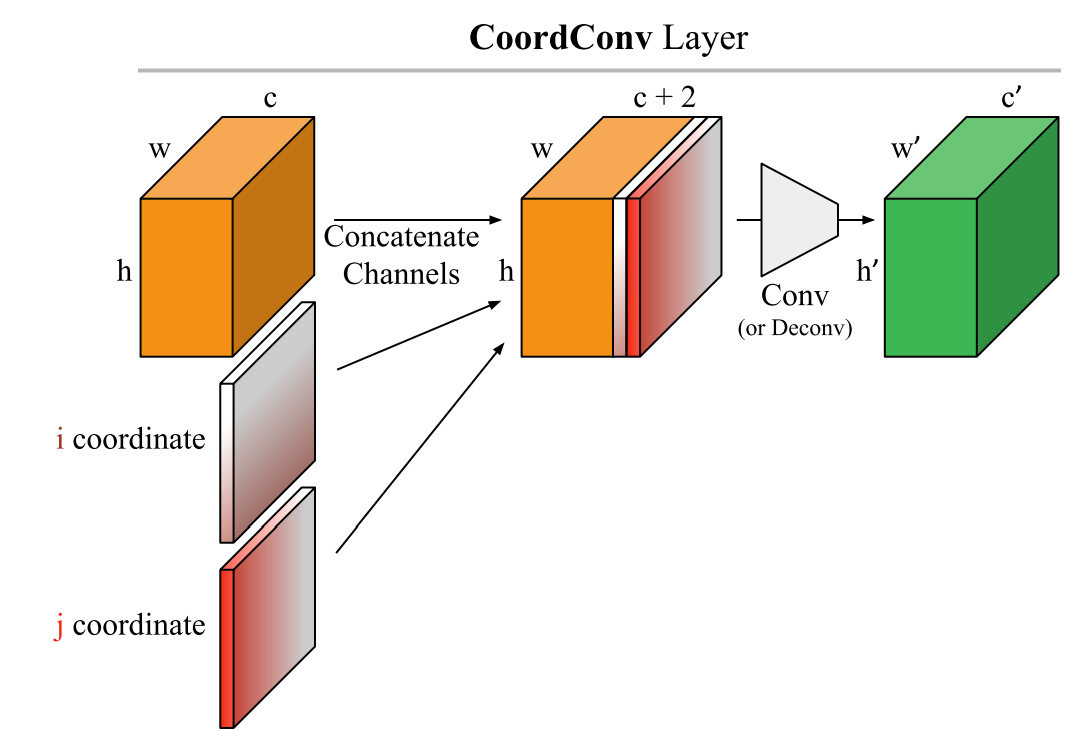

Сначала реализуем слой, добавляющий каналы с позиционным кодированием пикселей.

Идея представлена в статье [An intriguing failing of convolutional neural networks
and the CoordConv solution](https://arxiv.org/pdf/1807.03247). Авторы статьи предлагают использовать каналы из координат со значениями в $[-1, 1]$. 

**Tips:** используйте `torch.linspace`

In [32]:
class AddCoords(torch.nn.Module):
    @staticmethod
    def forward(x: torch.Tensor) -> torch.Tensor:
        """Concatenate positional information along channels dimension
        :param torch.Tensor x: (B, C,     H, W)
        :return:               (B, C + 2, H, W)
        :rtype: torch.Tensor
        """
        
        w = torch.linspace(-1, 1, x.shape[-1], device=x.device).unsqueeze(1)
        h = torch.linspace(-1, 1, x.shape[-2], device=x.device).unsqueeze(0)

        w, h = torch.broadcast_tensors(w, h)

        w_expanded = w.unsqueeze(0).expand(x.shape[0], -1, -1, -1)
        h_expanded = h.unsqueeze(0).expand(x.shape[0], -1, -1, -1)
        ret = torch.cat((x, w_expanded, h_expanded), dim=1)
        return ret

In [33]:
add_coords = AddCoords()
print(hide_specs(add_coords))
check_numel(add_coords, 0, 0)

x = torch.tensor(np.random.default_rng(6).normal(size=(3, 2, 5, 5)), dtype=torch.float32)
out = add_coords(x)

assert out.shape == (3, 4, 5, 5)

assert np.allclose(torch.sum(out[:, -1]).item(), 0.0)
assert np.allclose(torch.sum(out[:, -2]).item(), 0.0)

assert np.allclose(torch.sum(out[:, -1].abs()).item(), 45.0)
assert np.allclose(torch.sum(out[:, -2].abs()).item(), 45.0)

AddCoords()


Теперь объединим этот слой со свёрткой:

In [34]:
class CoordConv(torch.nn.Module):
    def __init__(self, in_channels: int, out_channels: int, kernel_size: int, **kwargs):
        """
        :param int in_channels: Convolution input channels
        :param int out_channels: Convolution output channels
        :param int kernel_size: Convolution kernel size
        :param dict kwargs: Convolution hyperparameters
        """
        super().__init__()
        
        self.addcoords = AddCoords()
        self.conv = torch.nn.Conv2d(in_channels + 2, out_channels, kernel_size, **kwargs)
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        :param torch.Tensor x:
        :return:
        :rtype: torch.Tensor
        """
        x = self.addcoords(x)
        x = self.conv(x)
        return x

In [35]:
coord_conv = CoordConv(in_channels=5, out_channels=7, kernel_size=3)
print(hide_specs(coord_conv))
check_numel(coord_conv, 448, 0)

x = torch.tensor(np.random.default_rng(6).normal(size=(3, 5, 11, 11)), dtype=torch.float32)
out = coord_conv(x)

assert out.shape == (3, 7, 9, 9)

CoordConv(
  (addcoords): AddCoords(...)
  (conv): Conv2d(...)
)


## `ResidualCoordConvBlock (0.5 балла)`

В качестве базового блока дискриминатора будем использовать две свёртки с координатным кодированием `CoordConv`, разделённые `LeakyReLU` с `negative_slope=0.2`.

Каждый блок понижает пространственную размерность в $2$ раза, используя Average Pooling. Свёрточные слои пространственную размерность не изменяют.

Также, в блоке используется Residual Connection. В случае, когда количество входных и выходных каналов не совпадает, предлагается перед сложением выполнить проекцию с использованием свёрточного слоя с ядром $1 \times 1$.

У вас должно получиться следующее:

$$
\begin{equation}
\begin{split}
\text{y} &= \text{network(x)} \\
\text{y} &= \frac{\text{pool(x)} + \text{pool(y)}}{\sqrt{2}}
\end{split}
\end{equation}
$$

**Tips:** 
* Не забудьте про инициализации слоёв перед функцией активации
* По необходимости используйте `torch.nn.Identity`
* По необходимости используйте `padding='same'`

In [36]:
class ResidualCoordConvBlock(torch.nn.Module):
    def __init__(self, in_channels: int, out_channels: int, kernel_size: int = 3):
        """
        :param int in_channels: Convolution input channels
        :param int out_channels: Convolution output channels
        :param int kernel_size: Convolution kernel size
        """
        super().__init__()
        
        # Create main branch
        self.network = torch.nn.Sequential(
            CoordConv(in_channels, out_channels, kernel_size, padding='same'),
            torch.nn.LeakyReLU(0.2, inplace=True),
            CoordConv(out_channels, out_channels, kernel_size, padding='same'),
            torch.nn.LeakyReLU(0.2, inplace=True),
        )
        
        # Create pooling layers
        self.avg_pool = torch.nn.AvgPool2d(2, 2)
        
        # Create projection layers
        self.projection = torch.nn.Conv2d(in_channels, out_channels, kernel_size=1) if in_channels != out_channels else lambda x: x
        

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        :param torch.Tensor x:
        :return:
        :rtype: torch.Tensor
        """
        
        return (self.avg_pool(self.network(x)) + self.avg_pool(self.projection(x))) / torch.sqrt(torch.tensor(2))


In [37]:
residual_coord_conv = ResidualCoordConvBlock(in_channels=5, out_channels=7, kernel_size=3)
print(hide_specs(residual_coord_conv))
check_numel(residual_coord_conv, 1064, 0)

x = torch.tensor(np.random.default_rng(7).normal(size=(3, 5, 11, 11)), dtype=torch.float32)
out = residual_coord_conv(x)

assert out.shape == (3, 7, 5, 5)

ResidualCoordConvBlock(
  (network): Sequential(
    (0): CoordConv(
      (addcoords): AddCoords(...)
      (conv): Conv2d(...)
    )
    (1): LeakyReLU(...)
    (2): CoordConv(
      (addcoords): AddCoords(...)
      (conv): Conv2d(...)
    )
    (3): LeakyReLU(...)
  )
  (avg_pool): AvgPool2d(...)
  (projection): Conv2d(...)
)


In [38]:
residual_coord_conv = ResidualCoordConvBlock(in_channels=7, out_channels=7, kernel_size=3)
print(hide_specs(residual_coord_conv))
check_numel(residual_coord_conv, 1148, 0)

x = torch.tensor(np.random.default_rng(8).normal(size=(3, 7, 11, 11)), dtype=torch.float32)
out = residual_coord_conv(x)

assert out.shape == (3, 7, 5, 5)

ResidualCoordConvBlock(
  (network): Sequential(
    (0): CoordConv(
      (addcoords): AddCoords(...)
      (conv): Conv2d(...)
    )
    (1): LeakyReLU(...)
    (2): CoordConv(
      (addcoords): AddCoords(...)
      (conv): Conv2d(...)
    )
    (3): LeakyReLU(...)
  )
  (avg_pool): AvgPool2d(...)
)


## `AdapterBlock (0.5 балла)`

Последний вспомогательный блок требуется для преобразования входного изображение с $3$ каналами в изображение с необходимым количеством каналов. Это необходимо так как при обучении дискриминатора число каналов на входе в модуль будет меняться в зависимости от разрешения изображения.

Будем использовать point-wise свёртку с функцией активации `LeakyReLU` и `negative_slope=0.2`:

In [39]:
class AdapterBlock(torch.nn.Module):
    def __init__(self, output_channels: int):
        """
        :param int output_channels: Convolution output channels
        """
        super().__init__()
        
        self.model =  torch.nn.Sequential(torch.nn.Conv2d(3, output_channels, 1), torch.nn.LeakyReLU(0.2))
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        :param torch.Tensor x: Batch of images  (B, 3, H, W)
        :return:               Batch of latents (B, C, H, W)
        :rtype: torch.Tensor
        """
        
        x = self.model(x)
        
        return x

In [40]:
adapter = AdapterBlock(16)
print(hide_specs(adapter))
check_numel(adapter, 64, 0)

x = torch.tensor(np.random.default_rng(8).normal(size=(5, 3, 11, 11)), dtype=torch.float32)
out = adapter(x)

assert out.shape == (5, 16, 11, 11)

AdapterBlock(
  (model): Sequential(
    (0): Conv2d(...)
    (1): LeakyReLU(...)
  )
)


## `Дискриминатор (1 балл)`

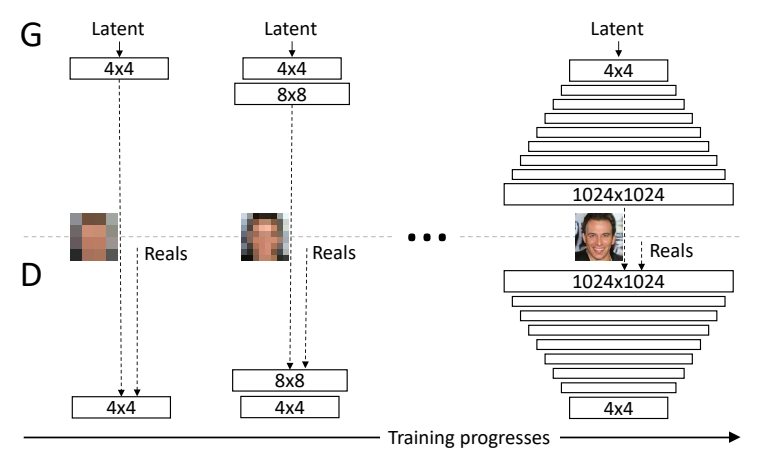

В качестве дискриминатора мы будем использовать Progressive GAN с максимальным размером изображения $256$.

Каждый блок дискриминатора понижает пространственную размерность в два раза, увеличивая число каналов.

Вам необходимо сделать следующую архитектуру дискриминатора:
```python
    blocks = torch.nn.ModuleList([
        ResidualCoordConvBlock(32, 64),    # 256x256 -> 128x128
        ResidualCoordConvBlock(64, 128),   # 128x128 -> 64x64
        ResidualCoordConvBlock(128, 256),  # 64x64   -> 32x32
        ResidualCoordConvBlock(256, 400),  # 32x32   -> 16x16
        ResidualCoordConvBlock(400, 400),  # 16x16   -> 8x8
        ResidualCoordConvBlock(400, 400),  # 8x8     -> 4x4
        ResidualCoordConvBlock(400, 400)   # 4x4     -> 2x2
    ])
```

Изначально мы будем учить изображения в разрешении $32 \times 32$ (то есть используются только $4$ последних блока дискриминатора), потом в $64 \times 64$ (только $5$ последних блоков дискриминатора). На inference будем использовать разрешение $256 \times 256$.

Вам необходимо использовать `AdapterBlock` блоки, чтобы количество каналов на входе в блоки дискриминатора было корректным — на выходе генератора, а также реальные изображения, имеют $3$ канала, тогда как блоки дискриминатора имеют другое число каналов.

Так как на выходе дискриминатора должно быть одно число — ненормированная вероятность того, что изображение реальное, то нужно поверх последнего блока применить слой агрегации. Предлагается использовать свёртку, которая агрегирует все каналы и пространственные размерности в одно число.

Так как обучение GAN является сложной задачей, а при повышении разрешения мы начинаем использовать ранее не обученные блоки, то возможна следующая проблема:

1. Мы хорошо обучились на разрешении $32 \times 32$, то есть обучили блоки `blocks[-4:]`
2. Мы увеличили разрешение до $64 \times 64$ и обучаем блоки `blocks[-5:]`
3. Мы затираем обученные веса из-за шумного блока `self.layers[-5]`

Для решения этой проблемы мы будем использовать линейную интерполяцию двух самых первых блоков, то при обучении на разрешении $64 \times 64$ в блок для разрешения $32 \times 32$ будем подавать линейную комбинацию:

$$
x = \alpha \;\text{Block}_{resolution=64}(\text{Adapter}_{\text{resolution} = 64}(x)) + (1 - \alpha) \;\text{Adapter}_{\text{resolution} = 32}(x)
$$

При этом $\alpha$ линейно увеличивается от $0$ до $1$, тем самым мы сделаем переход на новое разрешение более плавным.

Данная процедура называется **fade in**. Графически её можно изобразить, как на изображении ниже, панель $(b)$. Подробнее смотрите Секцию 2 и Фигуру 2 статьи [PROGRESSIVE GROWING OF GANS FOR IMPROVED QUALITY, STABILITY, AND VARIATION](https://arxiv.org/pdf/1710.10196).

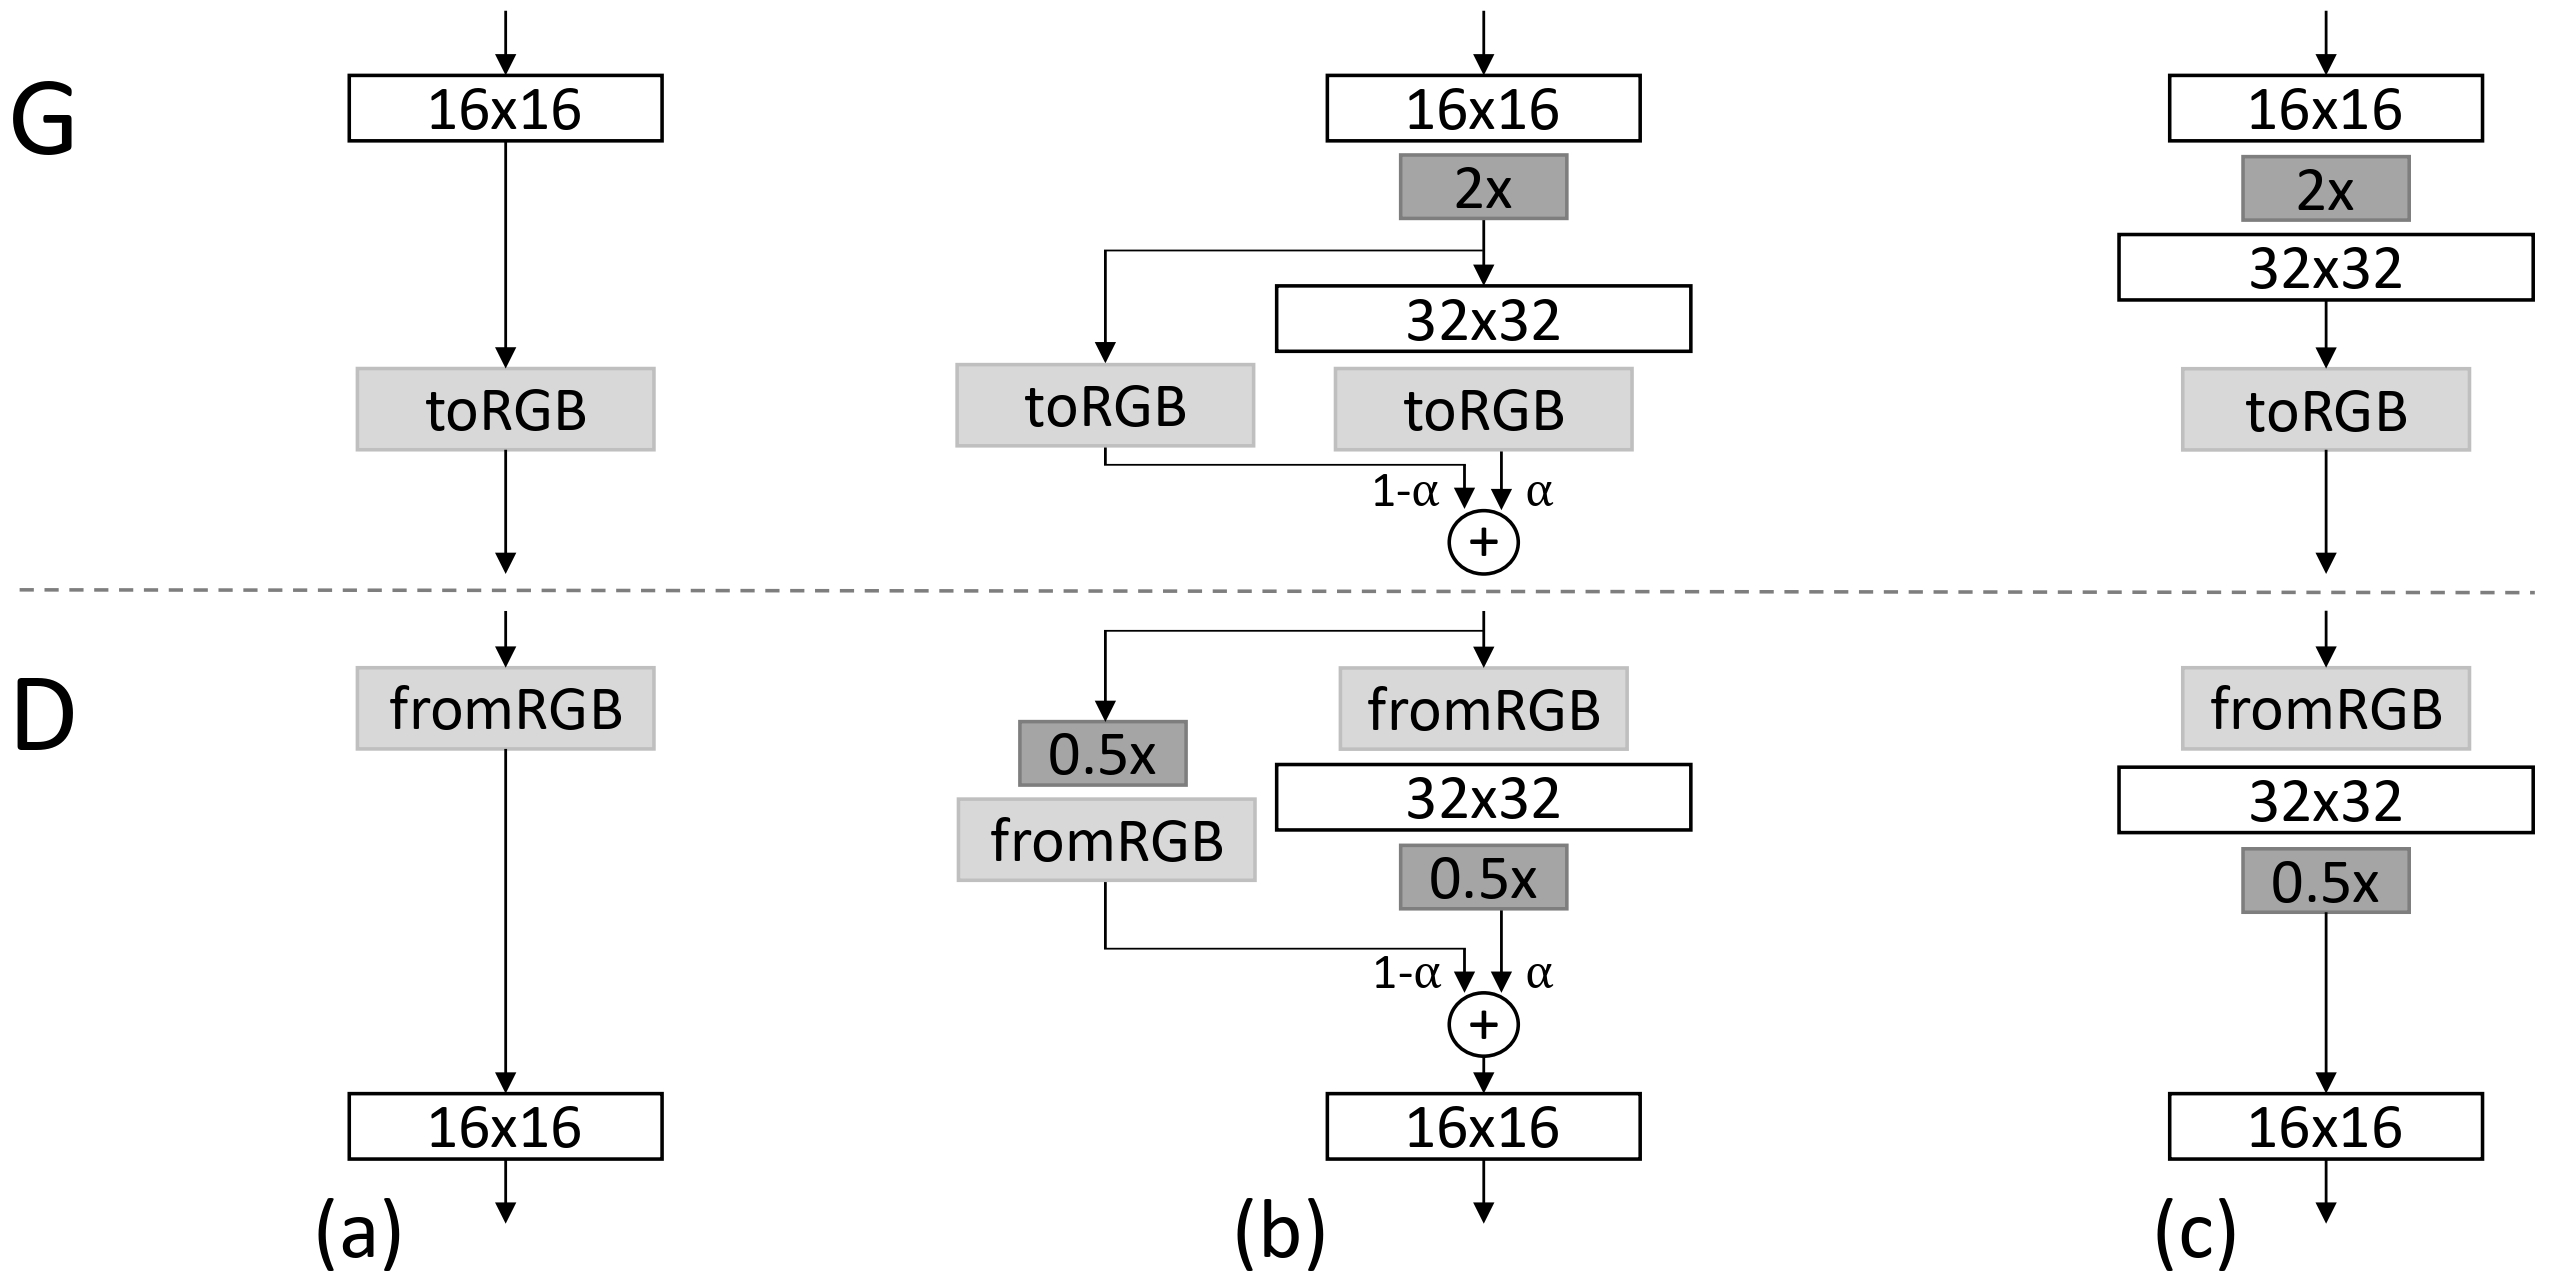

In [41]:
class ProgressiveDiscriminator(torch.nn.Module):
    """
    Implement of a progressive growing discriminator with ResidualCoordConv Blocks.
    """

    def __init__(self):
        super().__init__()
        
        # Mapping from image size to index to get necessary blocks and adapters 
        self.img_size_to_index = {2:7, 4:6, 8:5, 16:4, 32:3, 64:2, 128:1, 256:0}
        
        # Discriminator blocks
        self.blocks = torch.nn.ModuleList()
        input_channels = 32
        for output_channels in [64, 128, 256, 400, 400, 400, 400]:
            self.blocks.append(ResidualCoordConvBlock(input_channels, output_channels))
            input_channels = output_channels

        
        # Adapter blocks 
        self.fromRGB = torch.nn.ModuleList()
        for channels in [32, 64, 128, 256, 400, 400, 400, 400]:
            self.fromRGB.append(AdapterBlock(channels))

        
        # Final layer to aggregate feature maps
        self.final_layer = torch.nn.Conv2d(400, 1, 2)
        
    def forward(self, images: torch.Tensor, alpha: float) -> torch.Tensor:
        """
        :param torch.Tensor images: Batch of images  (B, 3, H, W)
        :param float alpha: Fade-in coefficient
        :return: Batch of predictions (B, 1)
        :rtype: torch.Tensor
        """
        
        x = images
        start = self.img_size_to_index[x.shape[-1]]
        x = self.fromRGB[start](x)

        for i, block in enumerate(self.blocks[start:]):
            if i == 1:
                x = alpha * x + (1 - alpha) * (self.fromRGB[start + 1](torch.nn.AvgPool2d(2, 2)(images)) if start != len(self.fromRGB) - 1 else None)
            x = block(x)


        x = self.final_layer(x).flatten(start_dim=1)
        return x

In [42]:
discriminator = ProgressiveDiscriminator()
optimizer = torch.optim.SGD(discriminator.parameters(), lr=0)

print(hide_specs(discriminator))
check_numel(discriminator.blocks, 12386896, 0)
check_numel(discriminator.fromRGB, 8320, 0)
check_numel(discriminator, 12396817, 0)

ProgressiveDiscriminator(
  (blocks): ModuleList(
    (0): ResidualCoordConvBlock(
      (network): Sequential(
        (0): CoordConv(
          (addcoords): AddCoords(...)
          (conv): Conv2d(...)
        )
        (1): LeakyReLU(...)
        (2): CoordConv(
          (addcoords): AddCoords(...)
          (conv): Conv2d(...)
        )
        (3): LeakyReLU(...)
      )
      (avg_pool): AvgPool2d(...)
      (projection): Conv2d(...)
    )
    (1): ResidualCoordConvBlock(
      (network): Sequential(
        (0): CoordConv(
          (addcoords): AddCoords(...)
          (conv): Conv2d(...)
        )
        (1): LeakyReLU(...)
        (2): CoordConv(
          (addcoords): AddCoords(...)
          (conv): Conv2d(...)
        )
        (3): LeakyReLU(...)
      )
      (avg_pool): AvgPool2d(...)
      (projection): Conv2d(...)
    )
    (2): ResidualCoordConvBlock(
      (network): Sequential(
        (0): CoordConv(
          (addcoords): AddCoords(...)
          (conv): Conv2d

In [43]:
x = torch.tensor(np.random.default_rng(9).normal(size=(5, 3, 32, 32)), dtype=torch.float32)
out = discriminator(x, alpha=0.5)

assert out.shape == (5, 1)

In [44]:
x = torch.tensor(np.random.default_rng(10).normal(size=(5, 3, 4, 4)), dtype=torch.float32)
out = discriminator(x, alpha=0.5)

assert out.shape == (5, 1)

In [45]:
optimizer.zero_grad()

x = torch.tensor(np.random.default_rng(11).normal(size=(5, 3, 8, 8)), dtype=torch.float32)
out = discriminator(x, alpha=0.5)
torch.linalg.norm(out).backward()

assert discriminator.fromRGB[-4].model[0].weight.grad is None
assert discriminator.fromRGB[-3].model[0].weight.grad is not None

assert discriminator.blocks[-3].network[0].conv.weight.grad is None
assert discriminator.blocks[-2].network[0].conv.weight.grad is not None

In [46]:
optimizer.zero_grad()

x = torch.tensor(np.random.default_rng(12).normal(size=(5, 3, 8, 8)), dtype=torch.float32)
out = discriminator(x, alpha=1.0)
loss = torch.linalg.norm(out)
loss.backward()

assert discriminator.fromRGB[-1].model[0].weight.grad is None
assert discriminator.fromRGB[-2].model[0].weight.grad.sum() == 0
assert discriminator.fromRGB[-3].model[0].weight.grad.sum() != 0
assert discriminator.fromRGB[-4].model[0].weight.grad is None

assert discriminator.blocks[-2].network[0].conv.weight.grad.sum() != 0
assert discriminator.blocks[-1].network[0].conv.weight.grad.sum() != 0

In [47]:
optimizer.zero_grad()

x = torch.tensor(np.random.default_rng(12).normal(size=(5, 3, 8, 8)), dtype=torch.float32)
out = discriminator(x, alpha=0.0)
loss = torch.linalg.norm(out)
loss.backward()

assert discriminator.fromRGB[-1].model[0].weight.grad is None
assert discriminator.fromRGB[-2].model[0].weight.grad.sum() != 0
assert discriminator.fromRGB[-3].model[0].weight.grad.sum() == 0
assert discriminator.fromRGB[-4].model[0].weight.grad is None

assert discriminator.blocks[-2].network[0].conv.weight.grad.sum() == 0
assert discriminator.blocks[-1].network[0].conv.weight.grad.sum() != 0

# `Часть 3. Цикл обучения (2 балла)`

## `Вспомогательные функции для логирования`

In [48]:
@torch.inference_mode()
def gen_imgs_log(config, generator, z, device, name):
    copied_config = copy.deepcopy(config)
    copied_config['img_size'] = config.img_size_vis
    copied_config['h_stddev'] = copied_config['v_stddev'] = 0

    with torch.cuda.amp.autocast():
        gen_imgs = generator(z.to(device), **copied_config)

    save_image(
        gen_imgs[:25], os.path.join(config.output_dir, f'{name}_fixed.png'),
        nrow=5, normalize=True
    )

    copied_config['h_mean'] += 0.5
    with torch.cuda.amp.autocast():
        gen_imgs = generator(z.to(device), **copied_config)

    save_image(
        gen_imgs[:25], os.path.join(config.output_dir, f'{name}_tilted.png'),
        nrow=5, normalize=True
    )

@torch.inference_mode()
def gen_random_imgs_log(config, generator, z, device, name):
    copied_config = copy.deepcopy(config)
    copied_config['img_size'] = config.img_size_vis
    copied_config['h_stddev'] = copied_config['v_stddev'] = 0
    copied_config['psi'] = 0.7

    with torch.cuda.amp.autocast():
        gen_imgs = generator(torch.randn_like(z).to(device),  **copied_config)

    save_image(
        gen_imgs[:25], os.path.join(config.output_dir, f'{name}_random.png'),
        nrow=5, normalize=True
    )

def save_all_models(
    config, ema_generator, generator, discriminator,
    optimizer_G, optimizer_D, scaler, epoch
):
    checkpoint = {
        "ema_generator": ema_generator.state_dict(), "scaler": scaler.state_dict(),
        "generator": generator.state_dict(), "discriminator": discriminator.state_dict(),
        "generator_opt": optimizer_G.state_dict(), "discriminator_opt": optimizer_D.state_dict(),

    }
    torch.save(checkpoint, os.path.join(config.output_dir, f'checkpoint_{epoch}.pth'))

В качестве функции потерь будем использовать Non-Saturating GAN loss с регуляризацией градиента дискриминатора:

$D$:

$$
\mathbb{E}_{I\sim p_{\mathcal{D}}} \Bigg[ f\Big(D_{\theta_{D}}(I)\Big) \Bigg] + \mathbb{E}_{z\sim p_{z}, \xi \sim p_{\xi}} \Bigg[ f\Big(-D_{\theta_{D}}(G_{\theta_{G}}(z, \xi))\Big) \Bigg] - \lambda |\nabla D_{\theta_{D}}(I)|^{2} \longrightarrow \max_{\theta_{D}} \tag{3.1}
$$

$G$:

$$
\mathbb{E}_{z\sim p_{z}, \xi \sim p_{\xi}} \Bigg[ f\Big(D_{\theta_{D}}(G_{\theta_{G}}(z, \xi))\Big) \Bigg] \longrightarrow \max_{\theta_{G}} \tag{3.2}
$$

Где
$$
f(u) = -\log(1 + e^{-u}) = \log\sigma(u) = -\text{Softplus}(-u)
$$

Сравним с обычным GAN лоссом. 

Перепишем выражение $(3)$, убрав регуляризатор и замечая, что $\sigma(-u) = 1 -\sigma(u)$:

$D$: 
$$
\mathbb{E}_{I\sim p_{\mathcal{D}}} \Bigg[ \log\sigma\Big(D_{\theta_{D}}(I)\Big) \Bigg] + \mathbb{E}_{z\sim p_{z}, \xi \sim p_{\xi}} \Bigg[ \log \big( 1 - \sigma\Big(D_{\theta_{D}}(G_{\theta_{G}}(z, \xi)) \big) \Big) \Bigg] \longrightarrow \max_{\theta_{D}} \tag{4.1}
$$

$G$: 
$$
\mathbb{E}_{z\sim p_{z}, \xi \sim p_{\xi}} \Bigg[ \log \sigma\Big(D_{\theta_{D}}(G_{\theta_{G}}(z, \xi)) ) \Big) \Bigg] \longrightarrow \max_{\theta_{G}} \tag{4.2}
$$

Стандартный GAN лосс:

$$
\mathbb{E}_{I\sim p_{\mathcal{D}}} \Bigg[ \log\sigma\Big(D_{\theta_{D}}(I)\Big) \Bigg] + \mathbb{E}_{z\sim p_{z}, \xi \sim p_{\xi}} \Bigg[ \log \big( 1 - \sigma\Big(D_{\theta_{D}}(G_{\theta_{G}}(z, \xi))\Big) \big) \Bigg] \longrightarrow \min_{\theta_{G}}\max_{\theta_{D}} \tag{5}
$$

Видно, что функционал для дискриминатора не меняется, а в функционале для генератора используется эвристика, что

$$
\mathbb{E}_{z\sim p_{z}, \xi \sim p_{\xi}} \Bigg[ \log \big( 1 - \sigma\Big(D_{\theta_{D}}(G_{\theta_{G}}(z, \xi))\Big) \big)\Bigg] \longrightarrow \min_{\theta_{G}} \sim \mathbb{E}_{z\sim p_{z}, \xi \sim p_{\xi}} \Bigg[ \log \sigma\Big(D_{\theta_{D}}(G_{\theta_{G}}(z, \xi)) ) \Big) \Bigg] \longrightarrow \max_{\theta_{G}}
$$

Можно показать, что при переходе от $(5)$ к $(4)$ стационарная точка не меняется, однако градиенты генератора будут значительно меньше затухать.

Так как мы решаем задачу GAN, то будем сначала делать шаг дискриминатора, далее шаг генератора.


Для обучения дискриминатора, нам нужно делать линейную интерполяцию, как обсуждалось в пункте выше. В данной работе вам предлагается использовать:

$$ \alpha = \min\Bigg(1, \frac{\text{step_current} - \text{step_last_upsample}}{\text{config.fade_steps}}\Bigg) $$

Параметр `nerf_noise` отвечает за добавление шума в процесс NeRF интегрирования при генерации изображений. Предлагается считать его по формуле:

$$ \text{nerf_noise} = \max\Bigg(0, 1 - \frac{\text{discriminator.step}}{5000}\Bigg) $$

Допишите функцию обучения GAN:

In [51]:
def train(config, device):
    _, train_config = extract_training_config(0, config)

    # Sample noise that will be used for logging
    fixed_z = torch.randn((25, 256), device='cpu')

    # Create generator
    generator = ImplicitGenerator3d(config.z_dim, config.hidden_dim, config.n_blocks).to(device)

    # Create discriminator
    discriminator = ProgressiveDiscriminator().to(device)

    # Create ema generator
    ema_generator = ImplicitGenerator3d(config.z_dim, config.hidden_dim, config.n_blocks).to(device)

    # Create optimizer for the generator
    optimizer_G = torch.optim.Adam(generator.parameters(),
                                   lr=train_config['gen_lr'],
                                   betas=config.betas,
                                   weight_decay=config.weight_decay
                                  )

    # Create optimizer for the discriminator
    optimizer_D = torch.optim.Adam(discriminator.parameters(),
                                   lr=train_config['disc_lr'],
                                   betas=config.betas,
                                   weight_decay=config.weight_decay
                                  )

    # Create scaler for the mixed precision training
    scaler = torch.cuda.amp.GradScaler()

    # ----------
    #  Training
    # ----------

    api = wandb.Api()
    api.client.execute(
        api.CREATE_PROJECT,
        {
            'entityName': config.wandb.entity,
            'name': config.wandb.project,
            'access': 'USER_READ',
        },
    )

    wandb.init(
        entity=config.wandb.entity,
        project=config.wandb.project,
        save_code=True,
        name=config.wandb.name,
        config=OmegaConf.to_container(config, resolve=True)
    )

    dataloader = None
    interior_step_bar = tqdm.tqdm(dynamic_ncols=True, total=config.n_epochs)

    discriminator.step = 0
    current_config = copy.deepcopy(config)
    while discriminator.step <= config.n_epochs:
        # Get current training config
        step_last_upsample, train_config = extract_training_config(discriminator.step, config)

        # Update learning rates from the training config
        for el in optimizer_G.param_groups:
            el['lr'] = train_config['gen_lr']

        for el in optimizer_D.param_groups:
            el['lr'] = train_config['disc_lr']

        # Get dataloader for the correct image resolution
        if not dataloader or dataloader.batch_size != train_config.batch_size:
            dataloader = get_dataloader(config.template, train_config['img_size'], train_config.batch_size)

        for idx, real_images in enumerate(dataloader):
            # Get current training config
            _, train_config = extract_training_config(discriminator.step, config)

            # If we finished training with current batch size start new epoch
            if dataloader.batch_size != train_config.batch_size:
                break

            # Set train mode
            generator.train()
            discriminator.train()

            # Move images to device
            real_images = real_images.to(device)

            # Update image_size, nerf_noise and fade alpha
            current_config.img_size = train_config['img_size']
            current_config.nerf_noise = max(0, 1 - discriminator.step / 5000)

            alpha = min(1, (discriminator.step - step_last_upsample) / current_config.fade_steps)

            # TRAIN DISCRIMINATOR
            with torch.cuda.amp.autocast():
                # Generate batch of fake images
                fake_images = generator(torch.randn(train_config.batch_size, config.z_dim, device=device), **current_config)

                # Compute predictions for the real and fake images
                real_images.requires_grad = True
                real_preds = discriminator(real_images, alpha)
                fake_preds = discriminator(fake_images, alpha)

            # Compute gradients of the discriminator w.r.t. to the input. Use torch.autograd.grad
            # Remember, that with mixed precision training all gradients
            #   are scaled w.r.t. scaler.get_scale(). Use this scale and scaler.scale()
            #   to correctly evaluate penalty

            
            real_grad = [p * (1 / (scaler.get_scale() + 1e-5)) for p in torch.autograd.grad(outputs=scaler.scale(torch.sum(real_preds)), inputs=real_images, create_graph=True)][0]

            with torch.cuda.amp.autocast():
                flatten = real_grad.flatten(start_dim=1)
                grad_penalty = torch.mean(flatten.norm(2, dim=1) ** 2)
                grad_penalty = config.r1_lambda * grad_penalty

                # Compute discriminator loss
                d_loss = torch.mean(torch.nn.functional.softplus(fake_preds)) + torch.mean(torch.nn.functional.softplus(-real_preds)) + grad_penalty

            # Clear gradients
            optimizer_D.zero_grad()

            # Scale loss and perform backward
            scaler.scale(d_loss).backward()

            # Perform gradient clipping (do not forget to unscale gradients)
            scaler.unscale_(optimizer_D)
            d_grad_norm = torch.nn.utils.clip_grad_norm_(discriminator.parameters(), current_config.grad_clip)

            # Make step of optimization
            scaler.step(optimizer_D)

            # TRAIN GENERATOR

            # Sample random noise
            z = torch.randn(train_config.batch_size, config.z_dim, device=device)

            with torch.cuda.amp.autocast():
                # Generate fake images
                fake_images = generator(z, **current_config)

                # Compute predictions for the fake images
                f_preds = discriminator(fake_images, alpha)

                # Compute generator loss
                g_loss = torch.mean(torch.nn.functional.softplus(-f_preds))

            # Clear gradients
            optimizer_G.zero_grad()

            # Scale loss and perform backward
            scaler.scale(g_loss).backward()

            # Perform gradient clipping (do not forget to unscale gradients)
            scaler.unscale_(optimizer_G)
            g_grad_norm = torch.nn.utils.clip_grad_norm_(generator.parameters(), current_config.grad_clip)

            # Make step of optimization
            scaler.step(optimizer_G)

            # Update scaler
            scaler.update()

            # Update EMA generator
            with torch.no_grad():
                ema_params_iter = iter(ema_generator.parameters())
                model_params_iter = iter(generator.parameters())
                for ema_params in ema_params_iter:
                    model_params = next(model_params_iter)
                    ema_params.mul_(config.ema_rate).add_(model_params, alpha=1 - config.ema_rate)

            interior_step_bar.update(1)
            if idx % 10 == 0:
                wandb.log(
                    {
                        'g_loss': g_loss.item(),
                        'd_loss': d_loss.item(),
                        'scaler': scaler.get_scale(),
                        'g_grad_norm': g_grad_norm.item(),
                        'd_grad_norm': d_grad_norm.item(),

                        'g_lr': train_config.gen_lr,
                        'd_lr': train_config.disc_lr,
                        'image_size': train_config.img_size
                    },
                    step=discriminator.step
                )

            if discriminator.step % config.sample_interval == 0:
                generator.eval()
                ema_generator.eval()

                gen_imgs_log(
                    current_config, generator=generator,
                    z=fixed_z, device=device, name=f'{discriminator.step}'
                )
                gen_imgs_log(
                    current_config, generator=ema_generator,
                    z=fixed_z, device=device, name=f'{discriminator.step}_ema'
                )

                gen_random_imgs_log(
                    current_config, generator=generator,
                    z=fixed_z, device=device, name=f'{discriminator.step}'
                )
                gen_random_imgs_log(
                    current_config, generator=ema_generator,
                    z=fixed_z, device=device, name=f'{discriminator.step}_ema'
                )

                wandb.log(
                    {
                        'fixed': wandb.Image(
                            os.path.join(config.output_dir, f'{discriminator.step}_fixed.png')
                        ),
                        'fixed_ema': wandb.Image(
                            os.path.join(config.output_dir, f'{discriminator.step}_ema_fixed.png')
                        ),
                        'tilted': wandb.Image(
                            os.path.join(config.output_dir, f'{discriminator.step}_tilted.png')
                        ),
                        'tilted_ema': wandb.Image(
                            os.path.join(config.output_dir, f'{discriminator.step}_ema_tilted.png')
                        ),
                        'random': wandb.Image(
                            os.path.join(config.output_dir, f'{discriminator.step}_random.png')
                        ),
                        'random_ema': wandb.Image(
                            os.path.join(config.output_dir, f'{discriminator.step}_ema_random.png')
                        )
                    },
                    step=discriminator.step
                )

            # In order to save memory 
            if discriminator.step in [0, 1000, 5000, 10000, 15000, 20000]:
                save_all_models(
                    config, ema_generator, generator, discriminator,
                    optimizer_G, optimizer_D, scaler, epoch=discriminator.step
                )

            discriminator.step += 1

In [52]:
config.n_epochs = 20000
config.output_dir = 'local'
config.sample_interval = 500
config.model_save_interval = 500

config.wandb = {
    'entity': 's02210480', # Ваш ник,
    'name': f'{config.output_dir}',
    'project': 'mmp_practicum_spring_2024|Task 05|Pi-GAN'
}

print(OmegaConf.to_yaml(config, resolve=True))

os.makedirs(config.output_dir, exist_ok=True)

template: ./carla/*.png
z_dim: 256
hidden_dim: 256
n_blocks: 8
r1_lambda: 5
ema_rate: 0.999
betas:
- 0
- 0.9
weight_decay: 0
grad_clip: 1.0
train_config:
- - 0
  - batch_size: 32
    img_size: 32
    gen_lr: 6.0e-05
    disc_lr: 0.0002
- - 10000
  - batch_size: 10
    img_size: 64
    gen_lr: 3.0e-05
    disc_lr: 0.0001
fov: 30
ray_start: 0.7
ray_end: 1.3
fade_steps: 10000
h_stddev: 3.141592653589793
v_stddev: 0.7417649320975901
v_mean: 0.7417649320975901
h_mean: 1.5707963267948966
num_steps: 12
img_size_vis: 64
n_epochs: 20000
output_dir: local
sample_interval: 500
model_save_interval: 500
wandb:
  entity: s02210480
  name: local
  project: mmp_practicum_spring_2024|Task 05|Pi-GAN



In [53]:
device = (
    torch.device('cuda') 
    if torch.cuda.is_available() else 
    torch.device('cpu')
)
device

device(type='cuda')

In [ ]:
set_global_seed(42)

try:
    train(config, device)
except KeyboardInterrupt:
    pass

wandb.finish()

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: s02210480. Use `wandb login --relogin` to force relogin


  0%|          | 0/20000 [00:00<?, ?it/s]

wandb: Network error resolved after 0:00:01.211070, resuming normal operation.


Теперь попробуем выполнить инференс нашей модели. 

Загрузим чекпоинт с `ema` весами модели:

In [ ]:
checkpoint_idx = 20000
checkpoint = torch.load(
    f"./{config.output_dir}/checkpoint_{checkpoint_idx}.pth", 
    map_location=torch.device('cpu')
)

ema_generator = ImplicitGenerator3d(z_dim=config.z_dim, hidden_dim=config.hidden_dim, n_blocks=config.n_blocks)
ema_generator.load_state_dict(checkpoint['ema_generator'])
ema_generator.to(device)
ema_generator.eval()

In [ ]:
images = []

for _ in range(25):
    with torch.inference_mode():
        z = torch.randn(1, config.z_dim, device=device)
        image = ema_generator(z, img_size=256, **config).cpu()
    images.append(image)
    
images = torch.cat(images, dim=0)

In [ ]:
fig, axes = plt.subplots(5, 5, figsize=(10, 10))

for idx, ax in enumerate(axes.reshape(-1)):
    ax.imshow(inverse_transform(images[idx]))
    ax.axis('off')
    
fig.tight_layout()
plt.show()

# `Часть 4. Finally, вращаемся`

Обученный генератор позволяет не просто создавать один вид на объект, но и менять направление взора за счёт изменения параметров интегрирования и точек, в которых вычисляются четвёртки $\sigma$, $\text{RGB}$. 

Визуализируем такой режим работы генератора. Внесём несколько изменений в процесс генерации:
1. Генерируем изображения в разрешении $256$
2. Используем truncation trick с $\psi = 0.7$
3. Для каждого луча сэмплируем $24$ точки на луче, в которых будет вычисляться цвет и плотность. Это в два раза больше, чем на обучении
4. Шум в процесс интегрирования не вносится

In [ ]:
video_config = OmegaConf.create(config)

video_config.seeds = list(range(9))
video_config.output_dir = os.path.join(config.output_dir, 'videos')
video_config.image_size = 256
video_config.ray_step_multiplier = 2
video_config.num_frames = 36

video_config.num_steps = config.num_steps * video_config.ray_step_multiplier
video_config.img_size = video_config.image_size
video_config.psi = 0.7
video_config.v_stddev = 0
video_config.h_stddev = 0
video_config.nerf_noise = 0

os.makedirs(video_config.output_dir, exist_ok=True)

Параметры `fov`, `h_mean`, `v_mean` определяют точку, из которой исходит направление взгляда. Создадим список значений параметров, которые соответствуют вращению вокруг объекта:

In [ ]:
trajectory = []
for t in np.linspace(0, 1, video_config.num_frames, dtype=float):
    pitch = math.pi / 4.0
    yaw = 2.0 * math.pi * t
    fov = video_config.fov
    
    trajectory.append((pitch, yaw, fov))

Теперь для каждого положения сгенерируем изображение с одним и тем же значением шума и объединим полученные изображения в видео:

In [ ]:
for seed in video_config.seeds:
    writer = skvideo.io.FFmpegWriter(
        os.path.join(video_config.output_dir, f'{seed}.mp4'), 
        outputdict={'-pix_fmt': 'yuv420p', '-crf': '21'}
    )

    g = torch.Generator(device=device)
    g.manual_seed(seed)
    z = torch.randn(1, config.z_dim, generator=g, device=device)
    
    frames = []
    with torch.inference_mode():
        for pitch, yaw, fov in tqdm.tqdm(trajectory):
            video_config.h_mean = float(yaw)
            video_config.v_mean = float(pitch)
            video_config.fov = float(fov)
            video_config.h_stddev = 0
            video_config.v_stddev = 0

            frame = ema_generator(z, **video_config)
            frames.append(inverse_transform(frame.squeeze(0)))

        for frame in frames:
            writer.writeFrame(np.array(frame))

        writer.close()

In [ ]:
grid_size = int(np.sqrt(len(video_config.seeds)))
grid = GridspecLayout(grid_size, grid_size)

for seed, (idx, jdx) in zip(video_config.seeds, product(range(grid.n_rows), range(grid.n_columns))):
    grid[idx, jdx] = Video.from_file(
        os.path.join(video_config.output_dir, f'{seed}.mp4'), width=240, height=240
    )
    
grid

# `Часть 5. FID (1 балл)`

Теперь, когда модель обучена и качество генерации оценено визуально, возникает вопрос, как получить объективную метрику качества модели. Один из вариантов получения объективной оценки это ответить на вопрос: насколько распределение генерируемых моделью изображений "похоже" на распределение истинных изображений.

Таким образом, мы свели задачу объективной оценки к нахождению схожести между распределениями.

Существует множество способов оценки схожести распределений. В области CV популярным способом является **FID (Fréchet Inception Distance)**. Данная метрика вычисляет *расстояние Вассерштейна-$2$* между распределениями активаций некоторой обученной свёрточной модели.

Подробнее смотрите в статье [GANs Trained by a Two Time-Scale Update Rule Converge to a Local Nash Equilibrium](https://arxiv.org/pdf/1706.08500).

Более конкретно, положим есть два множества изображений, которые мы хотим сравнить: 
$$A = \{a_{i}\}, B = \{b_{j}\}, a_{i}, b_{i} \in \mathcal{I}$$

Рассмотрим глубокий свёрточный feature extractor: 
$$M: \mathcal{I} \rightarrow \mathbb{R}^{d}$$

Предположим, что 

$$ 
M(a) \sim \mathcal{N}(\mu_{A}, \Sigma_{A}) \\
M(b) \sim \mathcal{N}(\mu_{B}, \Sigma_{B})
$$

Предположение метрики FID утверждает, что если распределения $M(a), M(b)$ близки друг к другу, то и множества изображений $A, B$ похожи. Данное утверждение было проверено эмпирически.

В качестве меры близости между распределениями используется *расстояние Вассерштейна-$2$*:

$$
\textbf{FID} = \mathcal{W}_{2}(\mathcal{N}(\mu_{A}, \Sigma_{A}), \mathcal{N}(\mu_{B}, \Sigma_{B})) = ||\mu_{A} - \mu_{B}||_{2}^{2} + \text{Tr}\Big( \Sigma_{A} + \Sigma_{B} - 2 \sqrt{\Sigma_{A}\Sigma_{B}} \Big) \tag{6}
$$

Стандартным выбором для модели выделения признаков $M$ является **Inception V3**. В частности, берутся активации после Average Pooling, что даёт размерность признакового вектора $d = 2048$.

Для подсчёта метрик обычно фиксируют некоторое количество сгенерированных изображений. Типичный размер $|A| = 5000, 50000$.

Реализуем подсчёт **FID**.

Сначала реализуем вспомогательную функцию для генерации изображений и сохранения их в заданную директорию:

In [ ]:
@torch.inference_mode()
def generate(n, template, generator, transform, batch_size, device):
    os.makedirs(os.path.dirname(template), exist_ok=True)
    
    generator.to(device)
    
    n_generated = 0
    
    pbar = tqdm.tqdm(desc=f'Generate images for the {template}', total=n)
    while n_generated < n:
        z = torch.randn(batch_size, video_config.z_dim, device=device)
        images = generator(z, **video_config).cpu()
        
        for image in images:
            image = transform(image)
            image.save(template.format(n_generated))
            
            n_generated += 1
            pbar.update(n=1)
            
            if n_generated >= n:
                break

Теперь загрузим модель для подсчёта активаций. Уберём последний линейный слой и дропаут для получения активаций после Average Pool:

In [ ]:
inception_model = torch.hub.load(
    'pytorch/vision:v0.10.0', 'inception_v3',
    weights=torchvision.models.Inception_V3_Weights.IMAGENET1K_V1
)
inception_model.dropout = torch.nn.Identity()
inception_model.fc = torch.nn.Identity()
inception_model.eval()

inception_transform = transforms.Compose([
    transforms.Resize(299),
    transforms.CenterCrop(299),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406], 
        std=[0.229, 0.224, 0.225]
    )
])

Реализуйте датасет обёртку для обработки папки с изображениями:

In [ ]:
class ImagesDataset(Dataset):
    def __init__(self, template: str, transform):
        """
        :param str template: Path to the images
        :param Callable[PIL.Image.Image, torch.Tensor] transform: Image transform
        """
        super().__init__()
        
        files = sorted(glob.glob(template))
        self.images_paths = np.array(files)
        self.transform = transform
        
    def __len__(self) -> int:
        """
        Number of images
        :rtype: int
        """
        
        return len(self.images_paths)
    
    def __getitem__(self, idx: int) -> torch.Tensor:
        """
        :param int idx: Image Id
        :return:
        :rtype: torch.Tensor
        """
        
        img_path = self.images_paths[idx]
        image = Image.open(img_path).convert('RGB')
        image = self.transform(image)
        return image

Теперь реализуем функцию для подсчёта активаций для всех изображений в заданной директории:

In [ ]:
@torch.inference_mode()
def get_activations(
    template: str, model: torch.nn.Module, transform, batch_size: int, device: torch.device
) -> np.ndarray:
    """Compute activations for all images specified by template
    :param str template: Path to the images
    :param torch.nn.Module model: Model that compute activations
    :param Callable[PIL.Image.Image, torch.Tensor] transform: Image transform
    :param int batch_size: Batch size to perform a forward pass
    :param torch.device device: Target device
    :return: 2D array of activations
    :rtype: np.ndarray
    """
    model.to(device)
    
    dataset = ImagesDataset(template, transform=transform)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    
    features = []
    for images in tqdm.tqdm(
        dataloader, total=len(dataloader), desc=f'Compute activations for the {template}'
    ):
        images = images.to(device)
        output = model(images).cpu()
        features.append(output)
        
    return torch.cat(features, dim=0).numpy()

In [ ]:
activations_real = get_activations(
    './carla/*.png', inception_model, inception_transform, batch_size=256, device=device
)

In [ ]:
assert activations_real.shape == (10000, 2048)
assert np.allclose(np.linalg.norm(activations_real), 1911.0, atol=1.0)

Теперь реализуем подсчёт **FID** по формуле $(6)$. 

**Tips:** для вычисления корня из матрицы используйте `scipy.linalg.sqrtm`. Учтите, что из-за численных неточностей, корень из матрицы может иметь небольшую комплексную компоненту. Отбросьте её при вычислении

In [ ]:
def compute_fid(activations_real: np.ndarray, activations_fake: np.ndarray) -> float:
    """
    :param np.ndarray activations_real: Activations for the real images
    :param np.ndarray activations_fake: Activations for the fake images
    :rtype: float
    """
    
    mean_real = np.sum(activations_real, axis=0) / activations_real.shape[0]
    mean_fake = np.sum(activations_fake, axis=0) / activations_fake.shape[0]
    
    centered_real = activations_real - mean_real
    centered_fake = activations_fake - mean_fake
    
    cov_real = np.dot(centered_real.T, centered_real) / (activations_real.shape[0] - 1)
    cov_fake = np.dot(centered_fake.T, centered_fake) / (activations_fake.shape[0] - 1)
    
    mean_diff = mean_real - mean_fake
    cov_product = np.dot(cov_real, cov_fake)
    cov_sqrt, _ = scipy.linalg.sqrtm(cov_product, disp=False)

    if np.iscomplexobj(cov_sqrt):
        cov_sqrt = cov_sqrt.real

    fid = np.sum(mean_diff**2) + np.trace(cov_real + cov_fake - 2 * cov_sqrt)
    
    return fid

In [ ]:
assert np.allclose(compute_fid(activations_real, activations_real), 0.0)
assert np.allclose(compute_fid(activations_real, np.ones((13, 2048))), 1203.0, atol=1.0)

Сгенерируем моделью множество изображений:

In [ ]:
generate(
    2000, os.path.join(config.output_dir, f'images_{checkpoint_idx}', '{0:05d}.png'),
    ema_generator, inverse_transform, batch_size=1, device=device
)

Посчитаем активации для данных изображений:

In [ ]:
activations_fake = get_activations(
    f'./{config.output_dir}/images_{checkpoint_idx}/*.png', 
    inception_model, inception_transform, batch_size=256, device=device
)

Теперь, можно вычислить **FID**:

In [ ]:
compute_fid(activations_real, activations_fake)

Посчитаем **FID** для некоторого набора чекпоинтов, чтобы понять динамику обучения. Для ускорения будем рендерить изображения в разрешении $128 \times 128$ и также возьмём меньшее количество изображений:

In [ ]:
fids = []
checkpoint_idxs = [0, 1000, 5000, 10000, 15000, 20000]
for checkpoint_idx in checkpoint_idxs:
    checkpoint = torch.load(
        f"./{config.output_dir}/checkpoint_{checkpoint_idx}.pth", 
        map_location=torch.device('cpu')
    )

    ema_generator = ImplicitGenerator3d(
        z_dim=config.z_dim, hidden_dim=config.hidden_dim, n_blocks=config.n_blocks
    )
    ema_generator.load_state_dict(checkpoint['ema_generator'])
    ema_generator.to(device)
    ema_generator.eval()
    
    video_config.img_size = 128
    generate(
        1000, os.path.join(config.output_dir, f'images_{checkpoint_idx}', '{0:05d}.png'),
        ema_generator, inverse_transform, batch_size=1, device=device
    )
    
    activations_fake = get_activations(
        f'./{config.output_dir}/images_{checkpoint_idx}/*.png', 
        inception_model, inception_transform, batch_size=256, device=device
    )
    fid = compute_fid(activations_real, activations_fake)
    
    print(f'For checkpoint_idx {checkpoint_idx} FID = {fid:.3f}')
    fids.append(fid)
    
    del ema_generator

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))

ax.plot(checkpoint_idxs, fids, marker='o')
ax.grid(True)

ax.set_xlabel('Epoch')
ax.set_title('FID')

fig.tight_layout()
plt.show()

Видно, что модель можно ещё долго дообучать и это будет значительно улучшать качество генерации.